`TTbarResCoffea` Notebook to perform the data-driven mistag-rate-based ttbar hadronic analysis. 
This module must be run twice: 
   1. Make the mistag rate in the "anti-tag and probe" selection 
and the expectation in the signal region from MC,
   1. Applies that mistag rate and the mod-mass procedure to the single-tag selection. 

These are all done in bins of
b-tag categories (0, 1, $\ge 2$) and rapidity ($|y| \le 1.0$, $|y| > 1.0$).
The signal region is two top-tagged jets. 
The background estimate is the single-tag selection weighted by the mistag rate from the
"anti-tag and probe" region, with the mass of the weighted jet set to a random
value from QCD MC in the 1-ttag region. 


The preselection is:
- AK4-based $H_{T} > 1100$ GeV (to be on the trigger plateau). 
- $\ge 2$ AK8 jets with AK8 $p_{T} > 400$ GeV and $|y| < 2.5$, loose jet ID applied from matched AK4 jets

The 1-tag selection adds:
- $\ge 1$ AK8 jet with top tagging applied to randomly-assigned tag jet. 


The anti-tag selection is disjoint from the 1-tag selection:
- $\ge 1$ AK8 jet with top tagging VETO applied to randomly-assigned tag jet. 


The 2-tag selection is:
- $\ge 2$ AK8 jets with top tagging applied to both leading jets. 


The ttbar candidate mass assumes the two leading top-tagged jets are the top quarks. 


In [1]:
import time

from coffea import hist
from coffea.analysis_objects import JaggedCandidateArray
import coffea.processor as processor
from awkward import JaggedArray
import numpy as np
import glob as glob
import itertools
import pandas as pd

In [2]:
xrootdstr1 = 'root://cmseos.fnal.gov//'
xrootdstr2 = 'root://cmsxrootd.fnal.gov//'
xrootdstr3 = 'root://cmsxrootd-site.fnal.gov/'

In [3]:
qcdfilename = 'QCD.txt'
with open(qcdfilename) as f:
    qcdfiles = [xrootdstr2 + s.strip() for s in f.readlines()]

In [4]:
ttbarfilename = 'TTJets_TuneCP5_13TeV-amcatnloFXFX-pythia8.txt'
with open(ttbarfilename) as f:
    ttbarfiles = [xrootdstr1 + s.strip() for s in f.readlines()]

In [5]:
jetdatafilename = 'JetHT_Data.txt'
with open(jetdatafilename) as f:
    jetdatafiles = [xrootdstr2 + s.strip() for s in f.readlines()]

In [6]:
from distributed import Client
client = Client('coffea-dask.fnal.gov:8786')

In [7]:
"""@TTbarResAnaHadronic Package to perform the data-driven mistag-rate-based ttbar hadronic analysis. 
"""
class TTbarResProcessor(processor.ProcessorABC):
    def __init__(self, htCut=1100., minMSD=105., maxMSD=210., tau32Cut=0.7, ak8PtMin=400., bdisc=0.7,
                writePredDist=True,isData=True,year=2019, UseLookUpTables=False):
        
        self.htCut = htCut
        self.minMSD = minMSD
        self.maxMSD = maxMSD
        self.tau32Cut = tau32Cut
        self.ak8PtMin = ak8PtMin
        self.bdisc = bdisc
        self.writePredDist = writePredDist
        self.writeHistFile = True
        self.isData = isData
        self.year=year
        self.UseLookUpTables = UseLookUpTables
        
        self.ttagcats = ["at", "0t", "1t", "2t"] #anti-tag, 0, 1, >=2 ttags
        self.btagcats = ["0b", "1b", "2b"]   # 0, 1, >=2 btags
        self.ycats = ['cen', 'fwd']          # Central and forward
        # Combine categories like "0bcen", "0bfwd", etc:
        self.anacats = [ t+b+y for t,b,y in itertools.product( self.ttagcats, self.btagcats, self.ycats) ]
        print(self.anacats)
        
        dataset_axis = hist.Cat("dataset", "Primary dataset")
        cats_axis = hist.Cat("anacat", "Analysis Category")
        
        jetmass_axis = hist.Bin("jetmass", r"Jet $m$ [GeV]", 50, 0, 500)
        jetpt_axis = hist.Bin("jetpt", r"Jet $p_{T}$ [GeV]", 50, 0, 2000)
        ttbarmass_axis = hist.Bin("ttbarmass", r"$m_{t\bar{t}}$ [GeV]", 50, 0, 5000)
        jeteta_axis = hist.Bin("jeteta", r"Jet $\eta$", 50, -4, 4)
        jetphi_axis = hist.Bin("jetphi", r"Jet $\phi$", 50, -3.14, 3.14)
        jetp_axis = hist.Bin("jetp", r"Jet $p$ [GeV]", 50, 0, 5000)
        
        subjetmass_axis = hist.Bin("subjetmass", r"SubJet $m$ [GeV]", 50, 0, 500)
        subjetpt_axis = hist.Bin("subjetpt", r"SubJet $p_{T}$ [GeV]", 50, 0, 2000)
        subjeteta_axis = hist.Bin("subjeteta", r"SubJet $\eta$", 50, -4, 4)
        subjetphi_axis = hist.Bin("subjetphi", r"SubJet $\phi$", 50, -3.14, 3.14)

        self._accumulator = processor.dict_accumulator({
            'ttbarmass': hist.Hist("Counts", dataset_axis, cats_axis, ttbarmass_axis),
            'jetmass':   hist.Hist("Counts", dataset_axis, cats_axis, jetmass_axis),
            'jetpt':     hist.Hist("Counts", dataset_axis, cats_axis, jetpt_axis),
            'jeteta':    hist.Hist("Counts", dataset_axis, cats_axis, jeteta_axis),
            'jetphi':    hist.Hist("Counts", dataset_axis, cats_axis, jetphi_axis),
            
            'subjetmass':   hist.Hist("Counts", dataset_axis, cats_axis, subjetmass_axis),
            'subjetpt':     hist.Hist("Counts", dataset_axis, cats_axis, subjetpt_axis),
            'subjeteta':    hist.Hist("Counts", dataset_axis, cats_axis, subjeteta_axis),
            'subjetphi':    hist.Hist("Counts", dataset_axis, cats_axis, subjetphi_axis),
            
            'numerator': hist.Hist("Counts", dataset_axis, cats_axis, jetp_axis),
            'denominator': hist.Hist("Counts", dataset_axis, cats_axis, jetp_axis),
            'cutflow': processor.defaultdict_accumulator(int),
            
        })
        # ---- String for appropriate look-up tables containing the mistag rates ---- #
        # ---- Should not be used when creating the mistag plots and lookup tables themselves ---- #
        if self.UseLookUpTables == True:
            self.lu = '/uscms_data/d1/acwillia/singularity/TTbarAllHadUprootFork/TTbarAllHadUproot/LookupTables/mistag_'
        else:
            pass
            
    @property
    def accumulator(self):
        return self._accumulator

    def process(self, df):
        
        output = self.accumulator.identity()
        
        #dataset = events.metadata['dataset']
        dataset = df['dataset']
        FatJets = JaggedCandidateArray.candidatesfromcounts(
            df['nFatJet'],
            pt=df['FatJet_pt'],
            eta=df['FatJet_eta'],
            phi=df['FatJet_phi'],
            mass=df['FatJet_mass'],
            msoftdrop=df['FatJet_msoftdrop'],
            jetId=df['FatJet_jetId'],
            tau1=df['FatJet_tau1'],
            tau2=df['FatJet_tau2'],
            tau3=df['FatJet_tau3'],
            tau4=df['FatJet_tau4'],
            n3b1=df['FatJet_n3b1'],
            btagDeepB=df['FatJet_btagDeepB'],
            deepTag_TvsQCD=df['FatJet_deepTag_TvsQCD'],
            deepTagMD_TvsQCD=df['FatJet_deepTagMD_TvsQCD']
            )
        # ---- Define Jets ---- #
        Jets = JaggedCandidateArray.candidatesfromcounts(
            df['nSubJet'],
            pt=df['Jet_pt'],
            eta=df['Jet_eta'],
            phi=df['Jet_phi'],
            mass=df['Jet_mass']
            )
        
        # ---- Get event weights from dataset ---- #
        if 'JetHT' in dataset: # If data is used...
            evtweights = np.ones(FatJets.size) # set all "data weights" to one
        else: # if Monte Carlo dataset is used...
            evtweights = df["Generator_weight"].reshape(-1, 1).flatten()
        
        # ---- Show all events ---- #
        output['cutflow']['all events'] += FatJets.size
        
        # ---- Show all events according to which dataset it used ---- #
        if 'TTbar' in dataset:
            output['cutflow']['all ttbar events'] += FatJets.size
            output['cutflow']['number of ttbar sets'] += 1
        elif 'QCD' in dataset:
            output['cutflow']['all qcd events'] += FatJets.size
            output['cutflow']['number of qcd sets'] += 1
        elif 'JetHT' in dataset:
            output['cutflow']['all JetHT events'] += FatJets.size
            output['cutflow']['number of JetHT sets'] += 1
        else:
            print('\ndataset not found\n')
        
        # ---- Apply HT Cut ---- #
        hT = Jets.pt.sum()
        passhT = (hT > self.htCut)
        evtweights = evtweights[passhT]
        FatJets = FatJets[passhT]
        
        # ---- FatJets Info ---- #
        oneFatJet = (FatJets.counts >= 1) # at least one fat jet
        FatJets = FatJets[oneFatJet]
        evtweights = evtweights[oneFatJet]
        output['cutflow']['one FatJets'] += oneFatJet.sum()
        
        twoFatJets = (FatJets.counts >= 2)
        FatJets = FatJets[twoFatJets]
        evtweights = evtweights[twoFatJets]
        output['cutflow']['two FatJets'] += twoFatJets.sum()

        jet_id = (FatJets.jetId > 0)
        
        FatJets = FatJets[jet_id]
        output['cutflow']['jet id'] += jet_id.any().sum()
        
        jetkincut_index = (FatJets.pt > self.ak8PtMin) & (np.abs(FatJets.eta) < 2.5) # eta cut here
        FatJets = FatJets[ jetkincut_index ]
        output['cutflow']['jet kin'] += jetkincut_index.any().sum()

        twoFatJetsKin = (FatJets.counts >= 2) # Whats the difference from twoFatJets ?
        FatJets = FatJets[twoFatJetsKin]
        evtweights = evtweights[twoFatJetsKin]
        output['cutflow']['two FatJets and jet kin'] += twoFatJetsKin.sum()
        
        # ---- Randomly Select AK8 Jet as TTbar Candidate --- #
        index = JaggedArray.fromcounts(np.ones(len(FatJets), dtype='i'), np.random.randint(2, size=len(FatJets)))
        jet0 = FatJets[index]
        jet1 = FatJets[1 - index]
        
        ttbarcands = jet0.cross(jet1) #FatJets[:,0:2].distincts()
        
        # ---- Look for more than one TTbar candidate and re-broadcast releveant arrays  ---- #
        oneTTbar = (ttbarcands.counts >= 1)
        output['cutflow']['>= one oneTTbar'] += oneTTbar.sum()
        ttbarcands = ttbarcands[oneTTbar]
        evtweights = evtweights[oneTTbar]
        FatJets = FatJets[oneTTbar]
         
        # ---- Apply Delta Phi Cut ---- #
        dPhiCut = (ttbarcands.i0.p4.delta_phi(ttbarcands.i1.p4) > 2.1).flatten()
        output['cutflow']['dPhi > 2.1'] += dPhiCut.sum()
        ttbarcands = ttbarcands[dPhiCut]
        evtweights = evtweights[dPhiCut]
        FatJets = FatJets[dPhiCut] 
        
        
        # ---- Get Analysis Categories ---- # 
        # ---- They are (central, forward)   cross   (0b,1b,>=2b) ---- #
        cen = np.abs(ttbarcands.i0.p4.y - ttbarcands.i1.p4.y) < 1.0
        fwd = (~cen)
        tau32_i0 = np.where(ttbarcands.i0.tau2>0,ttbarcands.i0.tau3/ttbarcands.i0.tau2, 0 )
        tau32_i1 = np.where(ttbarcands.i1.tau2>0,ttbarcands.i1.tau3/ttbarcands.i1.tau2, 0 )
        taucut_i0 = tau32_i0 < self.tau32Cut
        taucut_i1 = tau32_i1 < self.tau32Cut
        mcut_i0 = (self.minMSD < ttbarcands.i0.msoftdrop) & (ttbarcands.i0.msoftdrop < self.maxMSD) 
        mcut_i1 = (self.minMSD < ttbarcands.i1.msoftdrop) & (ttbarcands.i1.msoftdrop < self.maxMSD) 

        ttag_i0 = (taucut_i0) & (mcut_i0)
        ttag_i1 = (taucut_i1) & (mcut_i1)
        antitag = (~taucut_i0) & (mcut_i0) #Probe will always be ttbarcands.i1
        ttag0 = (~ttag_i0) & (~ttag_i1)
        ttag1 = ttag_i0 ^ ttag_i1
        ttag2 = ttag_i0 & ttag_i1

        btag_i0 = (ttbarcands.i0.btagDeepB > self.bdisc)
        btag_i1 = (ttbarcands.i1.btagDeepB > self.bdisc)
        
        btag0 = (~btag_i0) & (~btag_i1)
        btag1 = btag_i0 ^ btag_i1
        btag2 = btag_i0 & btag_i1
        
        antitag_probe = np.logical_and(antitag, ttag_i1) #Found an antitag and ttagged probe pair for mistag rate
      
        regs = [cen,fwd]
        btags = [btag0,btag1,btag2]
        ttags = [antitag,ttag0,ttag1,ttag2]
        cats = [ (t&b&y).flatten() for t,b,y in itertools.product( ttags, btags, regs) ]
        
        labels_and_categories = dict(zip( self.anacats, cats ))
        ttbarmass = ttbarcands.p4.sum().mass.flatten()
        jetpt = ttbarcands.pt.flatten()
        #print('Jet pt = ', jetpt)
        jeteta = ttbarcands.eta.flatten()
        jetphi = ttbarcands.phi.flatten()
        
        weights = evtweights.flatten()
        
        # ---- Define the SumW2 for MC Datasets ---- #
        if 'TTbar' in dataset:
            output['cutflow']['ttbar sumw'] += np.sum(weights)
            output['cutflow']['ttbar sumw2'] += np.sum(weights**2)
        if 'QCD' in dataset:
            output['cutflow']['qcd sumw'] += np.sum(weights)
            output['cutflow']['qcd sumw2'] += np.sum(weights**2)
        
        # ---- Define Momentum p of probe jet as the Mistag Rate variable; M(p) ---- #
        # ---- Transverse Momentum pT can also be used instead; M(pT) ---- #
        pT = ttbarcands.i1.pt.flatten()
        eta = ttbarcands.i1.eta.flatten()
        pz = np.sinh(eta)*pT
        p = np.absolute(np.sqrt(pT**2 + pz**2))
        
        # ---- Define the Numerator and Denominator for Mistag Rate ---- #
        numerator = np.where(antitag_probe, p, -9999) # If no antitag and tagged probe, move event to useless bin
        denominator = np.where(antitag, p, -9999) # If no antitag, move event to useless bin
        
        df = pd.DataFrame({"momentum":p}) # Used for finding values in LookUp Tables
        
        for ilabel,icat in labels_and_categories.items():
            ### ------------------------------------ Mistag Scaling ------------------------------------ ###
            if self.UseLookUpTables == True:
                filename = self.lu + str(dataset) + '_at' + str(ilabel[2:]) + '.csv' # get mistag/lookup filename
                file_df = pd.read_csv(filename) # read in values from lookup table
                bin_widths = file_df['p'].values # collect bins as written in .csv file
                wgts = file_df['M(p)'].values # collect mistag weights as function of p as written in file
                
                BinKey = np.arange(bin_widths.size) # Use as label for BinNumber column in the new dataframe
                Bins = np.arange(bin_widths.size+1)*100. # Temporary definition of bins as floats
                P = np.where(p>5000., 5000., p) # Avoids momentum larger than the allowed bin size; caps the momentum
                df['BinWidth'] = pd.cut(P, bins=Bins) # new dataframe column
                df['BinNumber'] = pd.cut(P, bins=Bins, labels=BinKey) # new dataframe column
                
                BinNumber = df['BinNumber'].values # Collect the Bin Numbers into a numpy array
                BinNumber = BinNumber.astype('int64') # Insures the bin numbers are integers
            
                WeightMatching = wgts[BinNumber] # Match 'wgts' with corresponding p bin using the bin number
                Weights = weights*WeightMatching # Include 'wgts' with the previously defined 'weights'
            else:
                Weights = weights # No mistag rates, no change to weights
            ###---------------------------------------------------------------------------------------------###
            output['cutflow'][ilabel] += np.sum(icat)
          
            output['ttbarmass'].fill(dataset=dataset, anacat=ilabel, 
                                ttbarmass=ttbarmass[icat],
                                weight=Weights[icat])
            output['jetpt'].fill(dataset=dataset, anacat=ilabel, 
                                jetpt=jetpt[icat],
                                weight=Weights[icat])
            output['jeteta'].fill(dataset=dataset, anacat=ilabel, 
                                jeteta=jeteta[icat],
                                weight=Weights[icat])
            output['jetphi'].fill(dataset=dataset, anacat=ilabel, 
                                jetphi=jetphi[icat],
                                weight=Weights[icat])
            output['numerator'].fill(dataset=dataset, anacat=ilabel, 
                                jetp=numerator[icat],
                                weight=Weights[icat])
            output['denominator'].fill(dataset=dataset, anacat=ilabel, 
                                jetp=denominator[icat],
                                weight=Weights[icat])
        
        return output

    def postprocess(self, accumulator):
        return accumulator

In [8]:
tstart = time.time()

fileset = {
    'QCD':qcdfiles,
    'TTbar':ttbarfiles,
    'JetHT':jetdatafiles
}

output = processor.run_uproot_job(fileset,
                                  treename='Events',
                                  processor_instance=TTbarResProcessor(UseLookUpTables=True),
                                  #executor=processor.dask_executor,
                                  #executor=processor.iterative_executor,
                                  executor=processor.futures_executor,
                                  executor_args={
                                      'client': client, 
                                      'nano':False, 
                                      'flatten':True, 
                                      'skipbadfiles':True,
                                      'workers': 7},
                                  chunksize=100000 #, maxchunks=400
                                 )

elapsed = time.time() - tstart
print(output)

['at0bcen', 'at0bfwd', 'at1bcen', 'at1bfwd', 'at2bcen', 'at2bfwd', '0t0bcen', '0t0bfwd', '0t1bcen', '0t1bfwd', '0t2bcen', '0t2bfwd', '1t0bcen', '1t0bfwd', '1t1bcen', '1t1bfwd', '1t2bcen', '1t2bfwd', '2t0bcen', '2t0bfwd', '2t1bcen', '2t1bfwd', '2t2bcen', '2t2bfwd']


/opt/conda/lib/python3.7/site-packages/coffea/processor/executor.py:550: UserWarning: Bad file source root://cmsxrootd.fnal.gov///store/data/Run2018D/JetHT/NANOAOD/Nano25Oct2019_ver2-v1/40000/6C6D3C8C-DB80-5D46-ABEA-8782BFD36FE1.root. Skipping.
  warnings.warn(w_str)
/opt/conda/lib/python3.7/site-packages/awkward/array/jagged.py:1035: RuntimeWarning: invalid value encountered in true_divide
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/lib/python3.7/site-packages/awkward/array/jagged.py:1035: RuntimeWarning: invalid value encountered in true_divide
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/lib/python3.7/site-packages/awkward/array/jagged.py:1035: RuntimeWarning: invalid value encountered in true_divide
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/lib/python3.7/site-packages/coffea/processor/executor.py:550: UserWarning: Bad file source root://cmsxrootd.fnal.gov///store/data/Run2018D/JetHT/NANOAOD/Nano25Oct2019_ver2-v1/60000/CAB


{'ttbarmass': <Hist (dataset,anacat,ttbarmass) instance at 0x7fa30dce3450>, 'jetmass': <Hist (dataset,anacat,jetmass) instance at 0x7fa30dce3990>, 'jetpt': <Hist (dataset,anacat,jetpt) instance at 0x7fa30dccc090>, 'jeteta': <Hist (dataset,anacat,jeteta) instance at 0x7fa30dcc1990>, 'jetphi': <Hist (dataset,anacat,jetphi) instance at 0x7fa30dcc1e50>, 'subjetmass': <Hist (dataset,anacat,subjetmass) instance at 0x7fa30dcad310>, 'subjetpt': <Hist (dataset,anacat,subjetpt) instance at 0x7fa30dcb8e50>, 'subjeteta': <Hist (dataset,anacat,subjeteta) instance at 0x7fa30dcb8f10>, 'subjetphi': <Hist (dataset,anacat,subjetphi) instance at 0x7fa30dc98d50>, 'numerator': <Hist (dataset,anacat,jetp) instance at 0x7fa30dc98f90>, 'denominator': <Hist (dataset,anacat,jetp) instance at 0x7fa30dc98b10>, 'cutflow': defaultdict_accumulator(<class 'int'>, {'all events': 1872015671, 'all JetHT events': 1711508144, 'number of JetHT sets': 17138, 'one FatJets': 20360331, 'two FatJets': 19896855, 'jet id': 18646

In [9]:
Total_nevts = output['cutflow']['all events']
TTbar_nevts = output['cutflow']['all ttbar events'] 
QCD_nevts = output['cutflow']['all qcd events']
nevts = output['cutflow']['all JetHT events']
QCD_nsets = output['cutflow']['number of qcd sets']
TTbar_nsets = output['cutflow']['number of ttbar sets']
Data_nsets = output['cutflow']['number of JetHT sets']
TTbar_sumw = output['cutflow']['ttbar sumw']
QCD_sumw = output['cutflow']['qcd sumw']
TTbar_sumw2 = output['cutflow']['ttbar sumw2']
QCD_sumw2 = output['cutflow']['qcd sumw2']

# ---- MC events ---- #
print('TTbar events = ', TTbar_nevts)
print('QCD events =   ', QCD_nevts)

# ---- Data events ---- #
print('Data events =  ', nevts)
print()

# ---- Compare events (Not Necessary...) ---- #
print('Total events =                     ', Total_nevts)
print('Monte Carlo = Total events?        ', TTbar_nevts+QCD_nevts == Total_nevts)
print('Monte Carlo + Data = Total events? ', TTbar_nevts+QCD_nevts+nevts == Total_nevts)
print()

# ---- Sum w and w2 info ---- #
print('TTbar sumw =   ', TTbar_sumw)
print('QCD sumw =     ', QCD_sumw)
print('TTbar sumw2 =  ', TTbar_sumw2)
print('QCD sumw2 =    ', QCD_sumw2)
print()

print('Number of QCD datasets Processed = ', QCD_nsets)
print('Number of TTbar datasets Processed = ', TTbar_nsets)
print('Number of JetHT datasets Processed = ', Data_nsets)

TTbar events =  142155064
QCD events =    18352463
Data events =   1711508144

Total events =                      1872015671
Monte Carlo = Total events?         False
Monte Carlo + Data = Total events?  True

TTbar sumw =    1006901.0
QCD sumw =      0.012474336224386207
TTbar sumw2 =   21841605096.0
QCD sumw2 =     2.854573501187563e-09

Number of QCD datasets Processed =  187
Number of TTbar datasets Processed =  1430
Number of JetHT datasets Processed =  17138


In [10]:
def mkdir_p(mypath):
    '''Creates a directory. equivalent to using mkdir -p on the command line'''

    from errno import EEXIST
    from os import makedirs,path

    try:
        makedirs(mypath)
    except OSError as exc: # Python >2.5
        if exc.errno == EEXIST and path.isdir(mypath):
            pass
        else: raise

In [11]:
def DoesDirectoryExist(mypath): #extra precaution (Probably overkill...)
    '''Checks to see if Directory exists before running mkdir_p'''
    import os.path
    from os import path
    
    if path.exists(mypath):
        pass
    else:
        mkdir_p(mypath)

In [12]:
import matplotlib.pyplot as plt
import warnings
import re # regular expressions
warnings.filterwarnings("ignore")

# ---- Reiterate categories ---- #
ttagcats = ["at", "0t", "1t", "2t"]
btagcats = ["0b", "1b", "2b"]
ycats = ['cen', 'fwd']

list_of_cats = [ t+b+y for t,b,y in itertools.product( ttagcats, btagcats, ycats) ]

# ---- List the Histograms Here ---- #
list_of_hists = ('ttbarmass', 'jetpt', 'jeteta', 'jetphi',
                 'numerator', 'denominator')

In [13]:
maindirectory = '/uscms_data/d1/acwillia/singularity/TTbarAllHadUprootFork/TTbarAllHadUproot' # change accordingly

In [14]:
stack_fill_opts = {'alpha': 0.8, 'edgecolor':(0,0,0,0.3)}
stack_error_opts = {'label':'Stat. Unc.', 'hatch':'///', 'facecolor':'none', 'edgecolor':(0,0,0,.5), 'linewidth': 0}
data_err_opts = {'linestyle': 'none', 'marker': '.', 'markersize': 10., 'color': 'k', 'elinewidth': 1}

In [ ]:
""" ---------------- CREATES MISTAG PLOTS ---------------- """
# ---- Only Use This Cell When LookUp Tables Are Not In Use (i.e. UseLookUpTables = False) ---- #
"""
SaveDirectory = maindirectory + '/MistagPlots/'
DoesDirectoryExist(SaveDirectory) # no need to create the directory several times
for iset in fileset:
    for icat in list_of_cats:
        title = iset + ' mistag ' + icat
        filename = 'mistag_' + iset + '_' + icat + '.' + 'png'
        Numerator = output['numerator'].integrate('anacat', icat).integrate('dataset', iset)
        Denominator = output['denominator'].integrate('anacat', icat).integrate('dataset', iset)
        mistag = hist.plotratio(num = Numerator, denom = Denominator,
                                error_opts={'marker': '.', 'markersize': 10., 'color': 'k', 'elinewidth': 1},
                                unc = 'num')
        plt.title(title)
        plt.ylim(bottom = 0, top = 1.0)
        plt.savefig(SaveDirectory+filename, bbox_inches="tight")
        print(filename + ' saved')
"""

In [ ]:
""" ---------------- LOOK UP TABLE ---------------- """
# ---- Only Use This Cell When LookUp Tables Are Not In Use (i.e. UseLookUpTables = False) ---- #
"""
SaveDirectory = maindirectory + '/LookupTables/'
DoesDirectoryExist(SaveDirectory)
for iset in fileset:
    print('\t\tfileset: ' + iset + '\n*****************************************************\n')
    for icat in list_of_cats:
        title = iset + ' mistag ' + icat
        filename = 'mistag_' + iset + '_' + icat + '.' + 'csv'
        
        Numerator = output['numerator'].integrate('anacat',icat).integrate('dataset',iset)
        Denominator = output['denominator'].integrate('anacat',icat).integrate('dataset',iset)
        
        N_vals = Numerator.values()[()]
        D_vals = Denominator.values()[()]
    
        mistag_vals = np.where(D_vals > 0, N_vals / D_vals, 0)
        
        p_vals = [] # Momentum values
        for iden in Numerator.identifiers('jetp'):
            p_vals.append(iden)
        
        print('fileset:  ' + iset)
        print('category: ' + icat)
        print('________________________________________________\n')

        d = {'p': p_vals, 'M(p)': mistag_vals}
        
        df = pd.DataFrame(data=d)
        
        with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
            print(df)
        print('\n')
        
        df.to_csv(SaveDirectory+filename) # use later to collect bins and weights for re-scaling
"""

In [32]:
""" ---------------- Luminosity Scaling ---------------- """
Lum = 35900. # pb^-1 ; 139230 taken from  https://github.com/b2g-nano/TTbarAllHad/blob
                                #                 /master/test/controlplots/control_plots.ipynb
TTbar_BR = 0.457 # 0.442 from PDG 2018
ttbar_xs = 831.76 * TTbar_BR  #pb
qcd_xs = 2022100000. #pb 

TTbar_sumw_evt_file = TTbar_sumw/(TTbar_nevts/TTbar_nsets) # sum of weights per events per file
QCD_sumw_evt_file = QCD_sumw/(QCD_nevts/QCD_nsets) # sum of weights per events per file

#---- Integrated Luminosity from Data ----#
Lum_data = nevts / (ttbar_xs+qcd_xs)

# ---- Using SumW/Number of events/Number of files used ---- #
TTbar_nevts_wgt = 142155064 * TTbar_sumw_evt_file # 142155064 from dasgoclient -query="summary dataset=/TTJets_TuneCP5_13TeV-amcatnloFXFX-pythia8/RunIIAutumn18NanoAODv7-Nano02Apr2020_102X_upgrade2018_realistic_v21_ext1-v1/NANOAODSIM"
QCD_nevts_wgt = 18455107 * QCD_sumw_evt_file # 18455107 from dasgoclient -query="summary dataset=/QCD_Pt-15to7000_TuneCP5_Flat_13TeV_pythia8/RunIIFall17NanoAODv7-PU2017_12Apr2018_Nano02Apr2020_102X_mc2017_realistic_v8-v1/NANOAODSIM"

# ---- Using Sum W2 ---- #
TTbar_nevts_wgt2 = TTbar_nevts * TTbar_sumw2
QCD_nevts_wgt2 = QCD_nevts * QCD_sumw2 #Less accurate for larger MC samples

# ---- Scale Factors for Monte Carlo Histograms ---- #
# ---- Use either sumw or sumw2 re-weighted evts ---- #
TTbar_sf = (Lum_data * ttbar_xs / TTbar_nevts_wgt) 
QCD_sf = (Lum_data * qcd_xs / QCD_nevts_wgt)
scales = {'TTbar': TTbar_sf,
          'QCD': QCD_sf}

print('TTbar sumw/evts/files = ', TTbar_sumw_evt_file)
print('QCD sumw/evts/files =   ', QCD_sumw_evt_file)
print()
print('TTbar sumw2 =  ', TTbar_sumw2)
print('QCD sumw2 =    ', QCD_sumw2)
print()
print('scaled TTbar nevts =               ', TTbar_nevts_wgt)
print('scaled QCD nevts =                 ', QCD_nevts_wgt)
print()
print('TTbar allHad xs =                  ', ttbar_xs, ' pb')
print('QCD xs =                           ', qcd_xs, ' pb')
print()
print('Integrated Luminosity in paper =   ', Lum, ' pb^(-1)')
print('Integrated Luminosity Calculated = ', Lum_data, ' pb^(-1)')
print()
print('TTbar scale factor =               ', TTbar_sf)
print('QCD scale factor =                 ', QCD_sf)

TTbar sumw/evts/files =  10.128857808399987
QCD sumw/evts/files =    1.2710560288067168e-07

TTbar sumw2 =   21841605096.0
QCD sumw2 =     2.854573501187563e-09

scaled TTbar nevts =                1439868430.0
scaled QCD nevts =                  2.345747501462304

TTbar allHad xs =                   380.11432  pb
QCD xs =                            2022100000.0  pb

Integrated Luminosity in paper =    35900.0  pb^(-1)
Integrated Luminosity Calculated =  0.8464011781172008  pb^(-1)

TTbar scale factor =                2.2344347689268988e-07
QCD scale factor =                  729621504.9590219


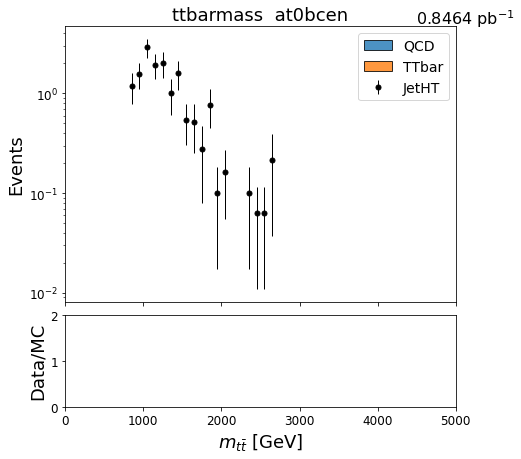

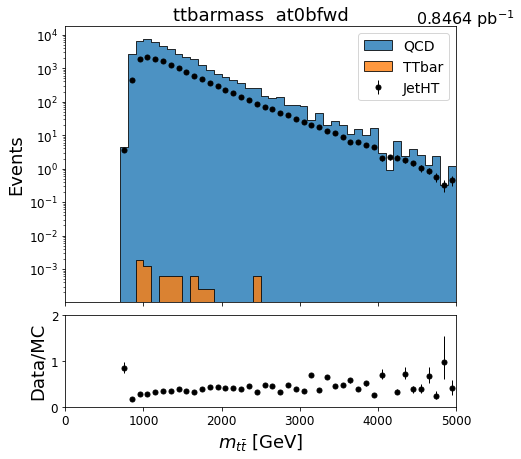

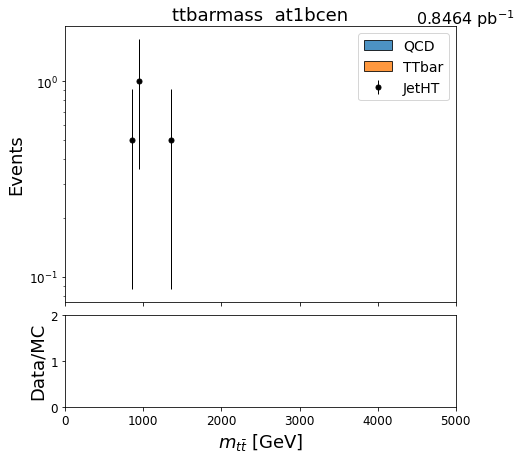

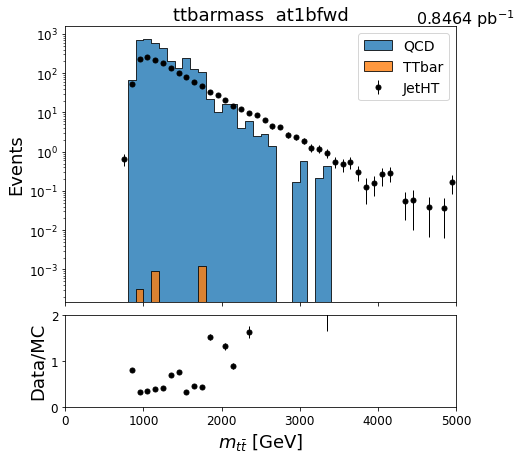

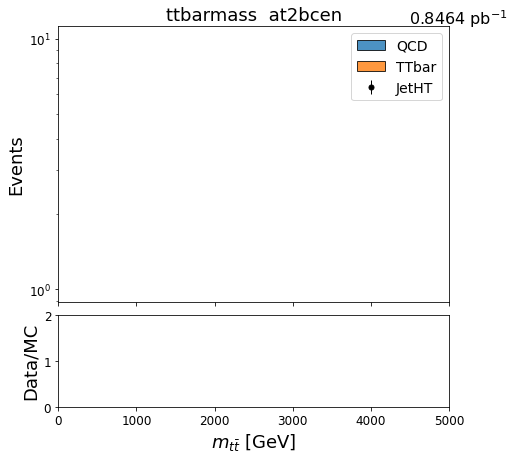

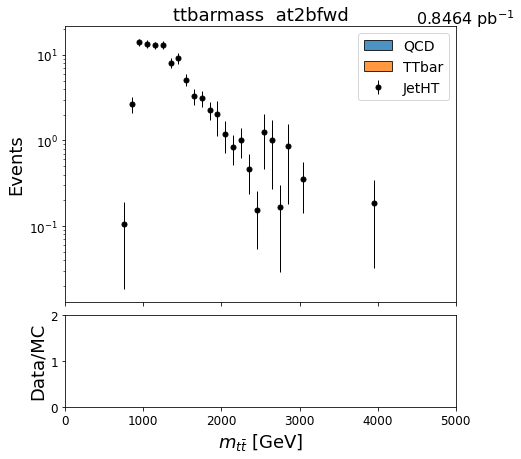

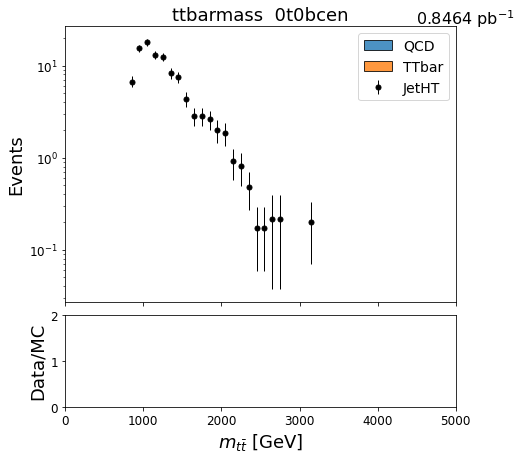

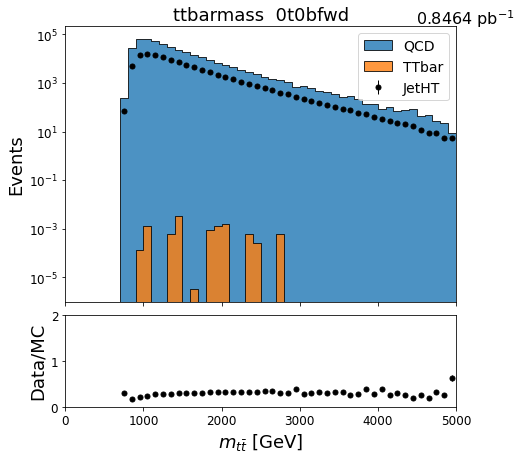

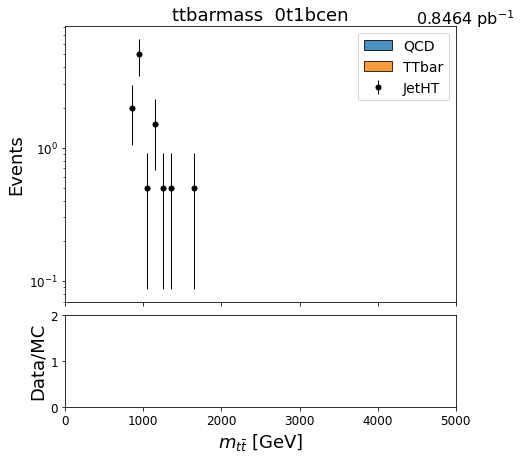

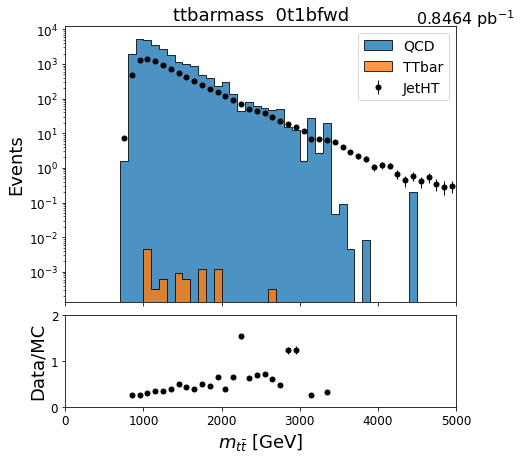

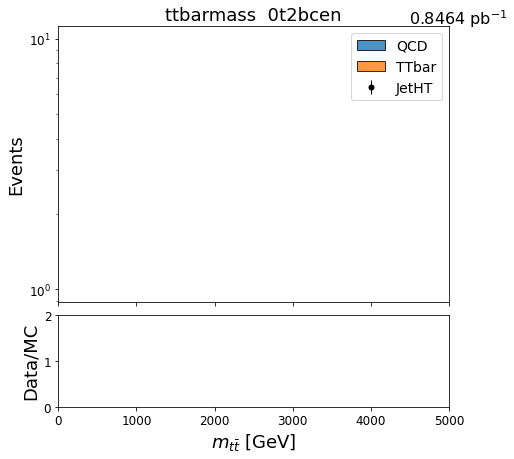

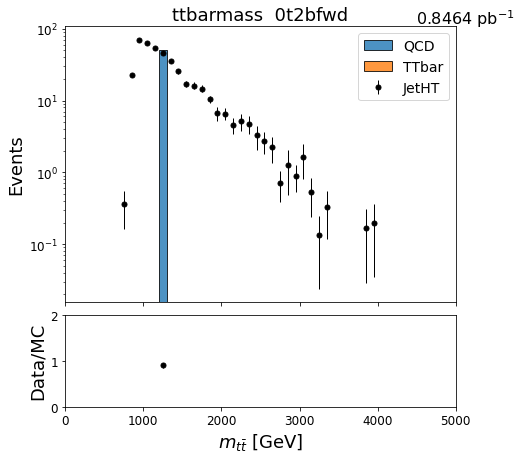

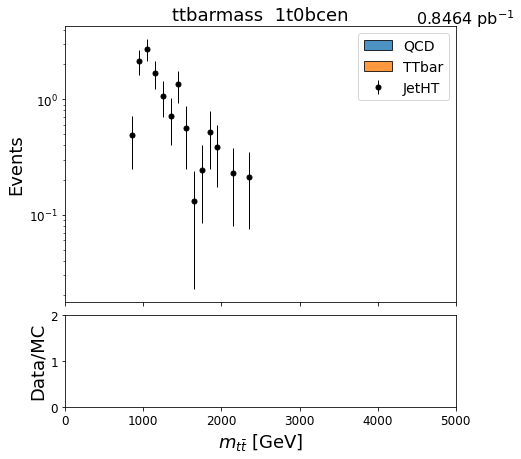

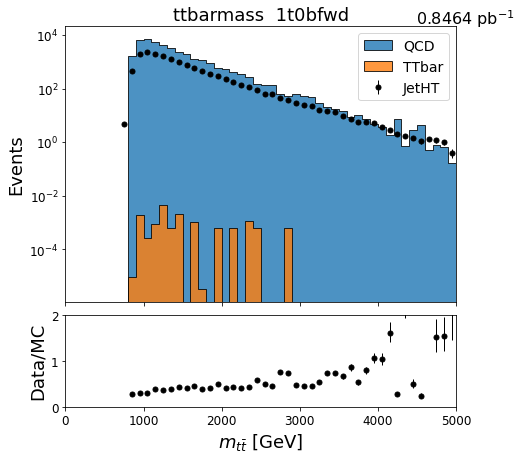

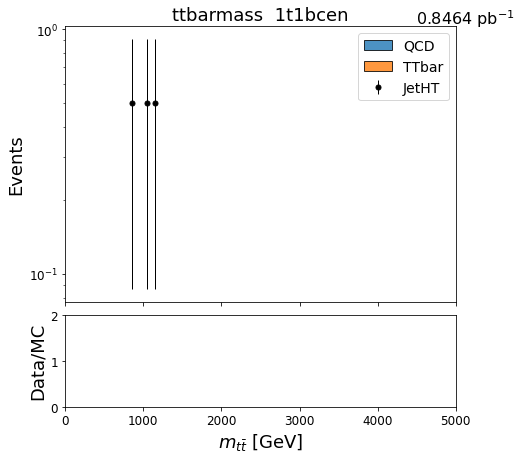

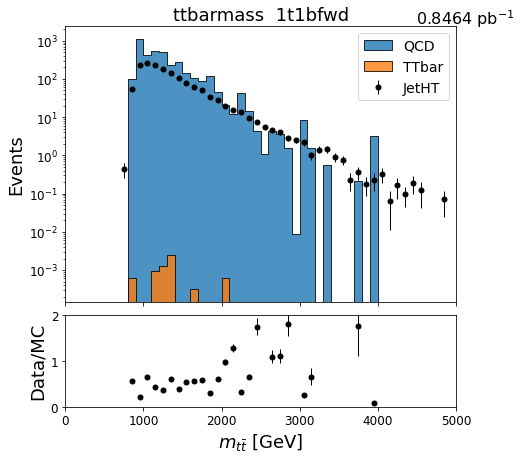

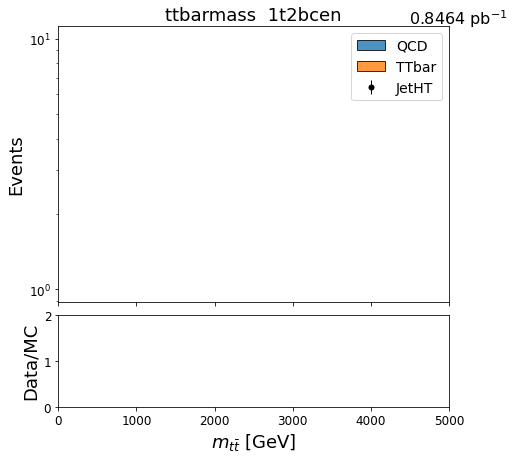

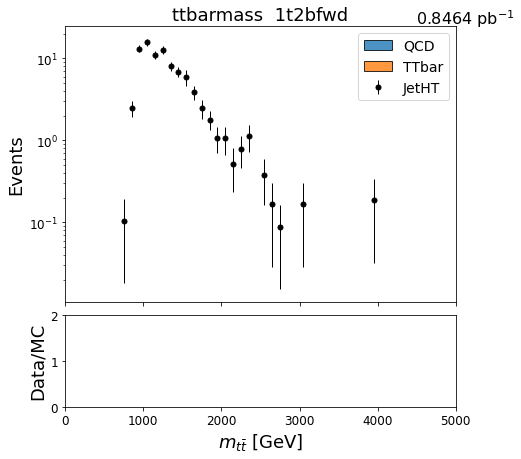

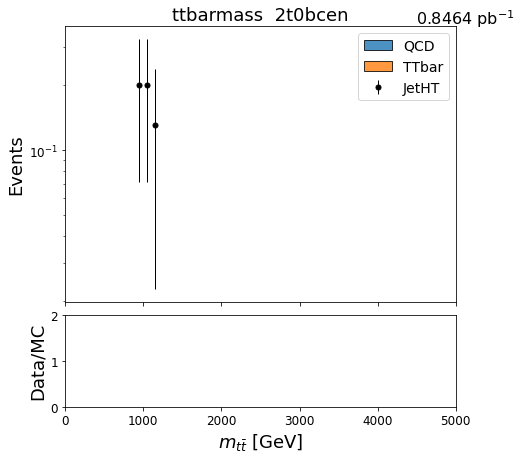

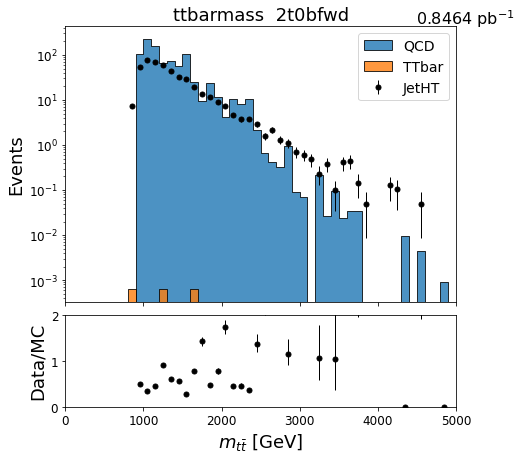

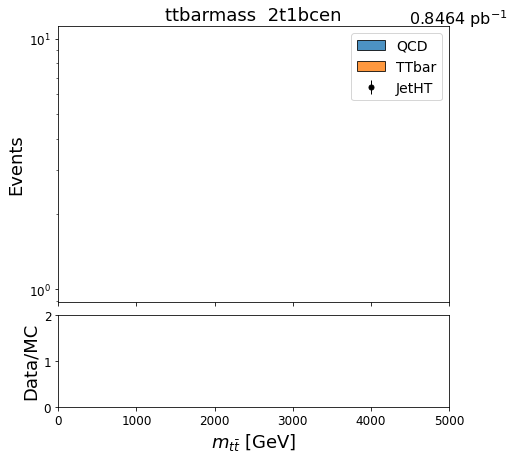

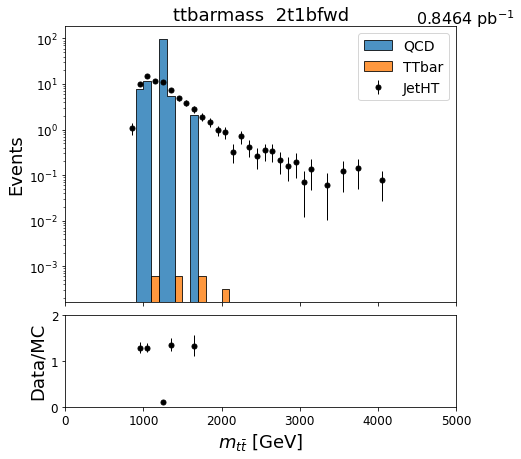

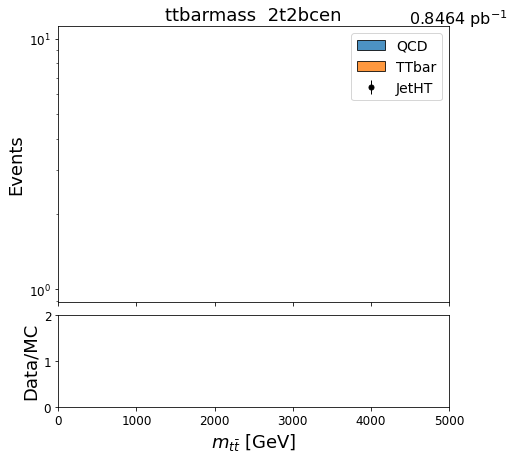

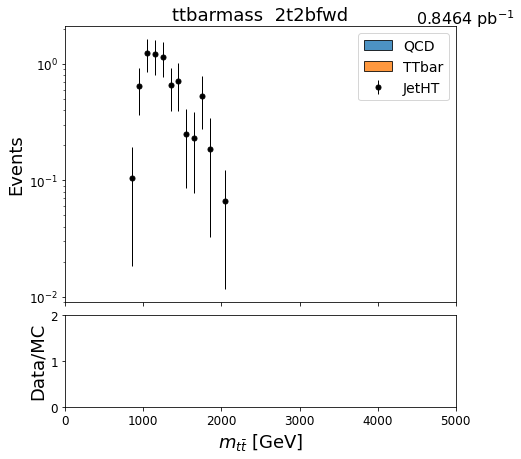

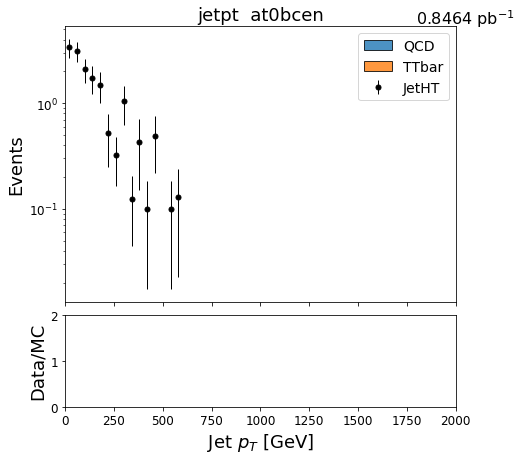

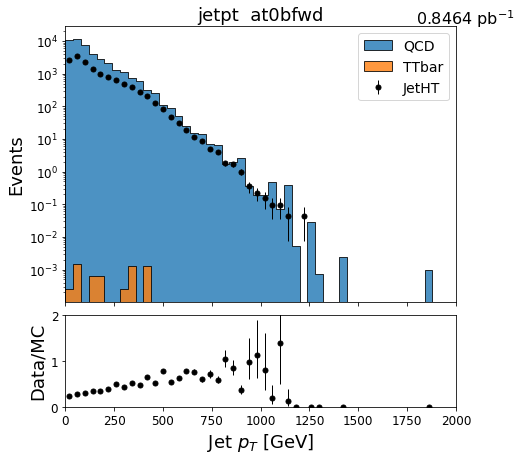

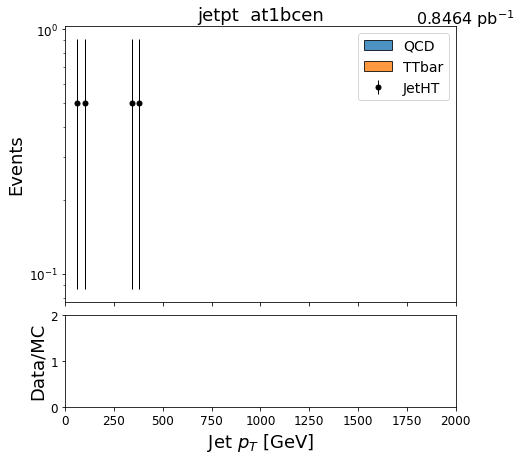

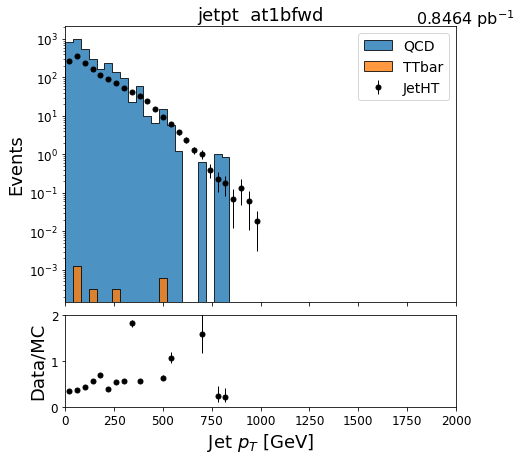

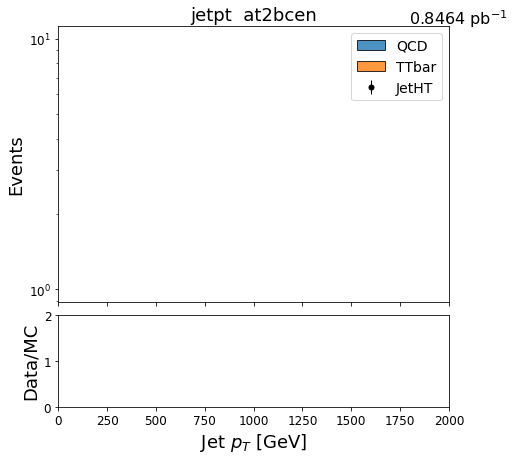

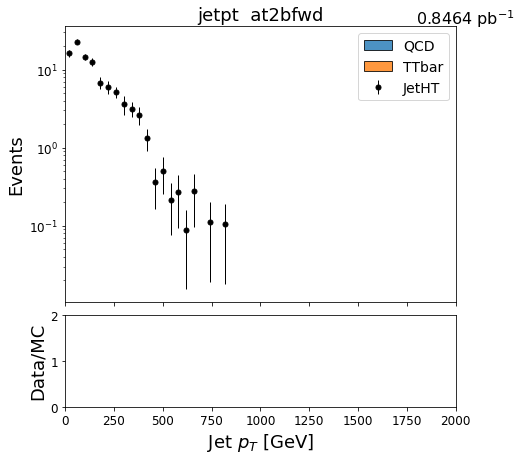

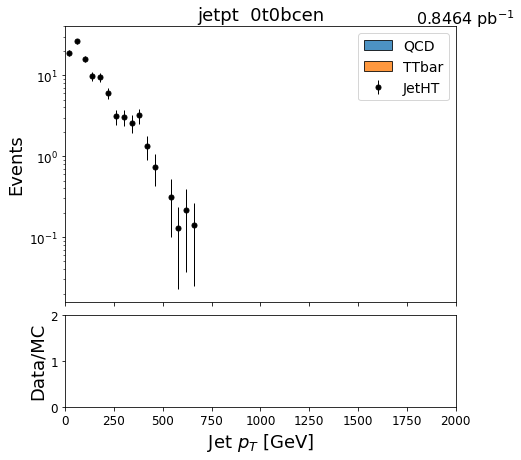

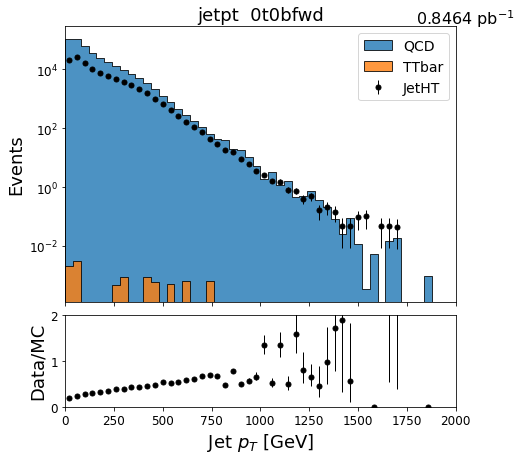

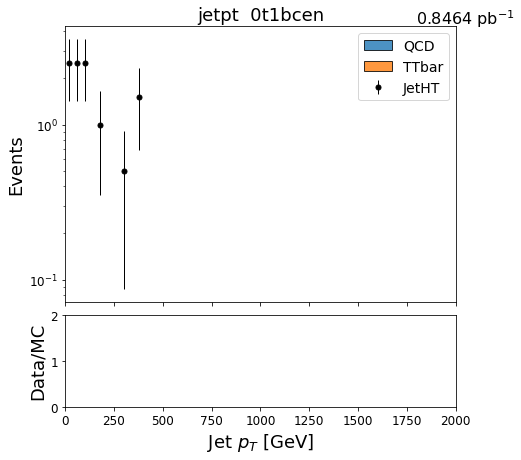

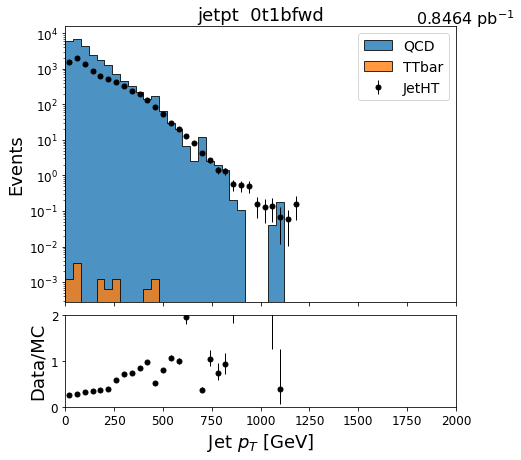

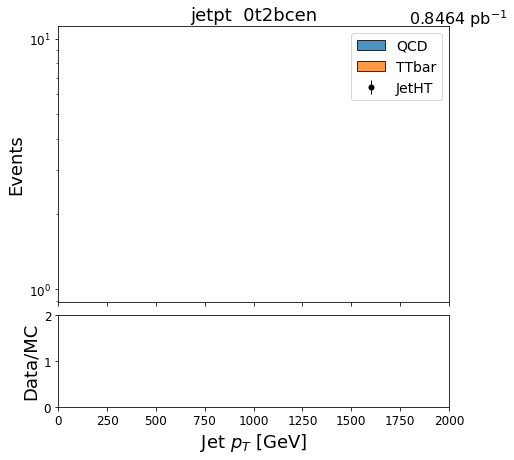

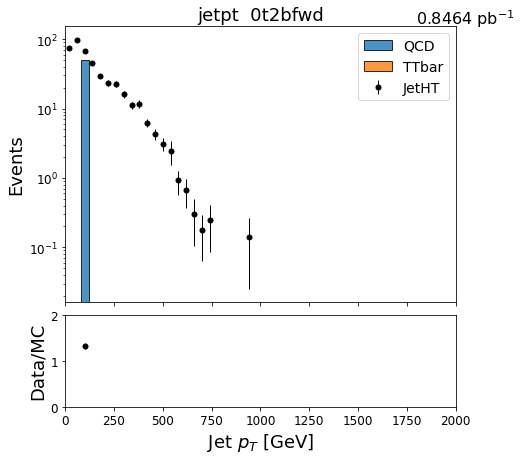

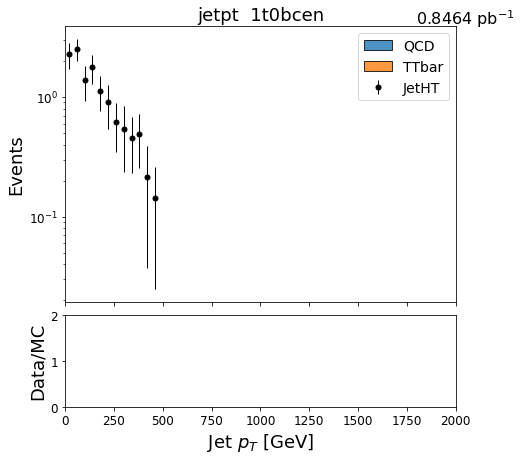

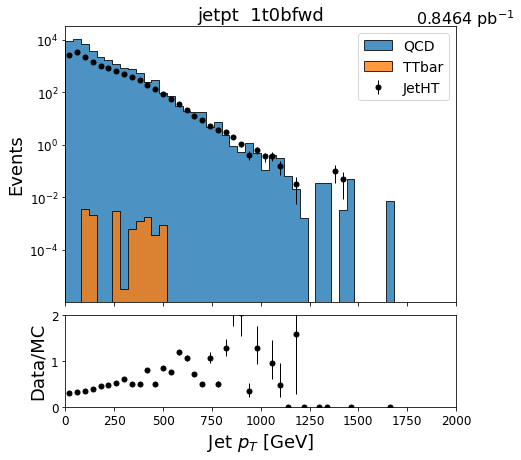

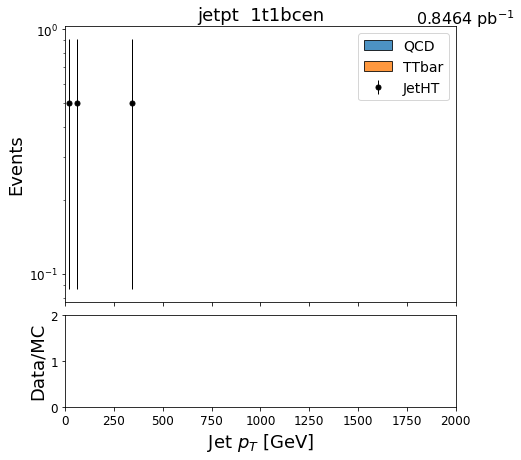

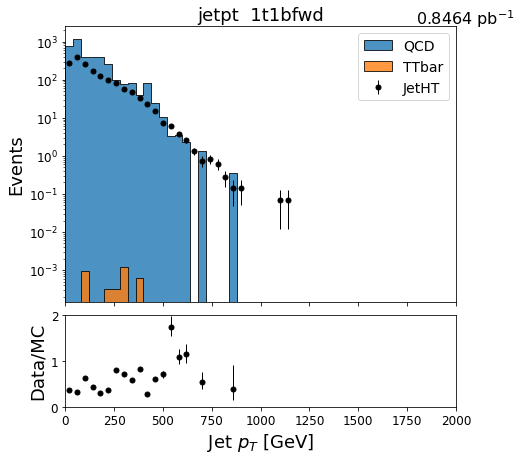

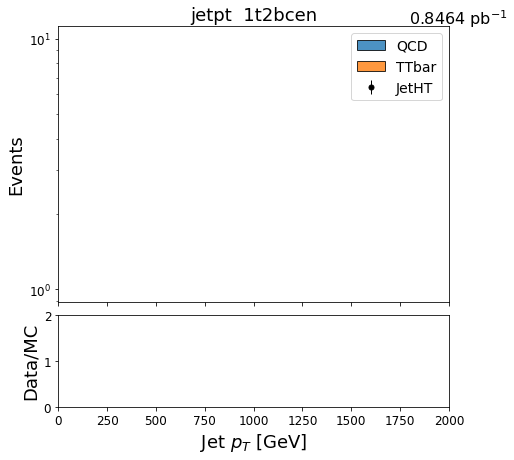

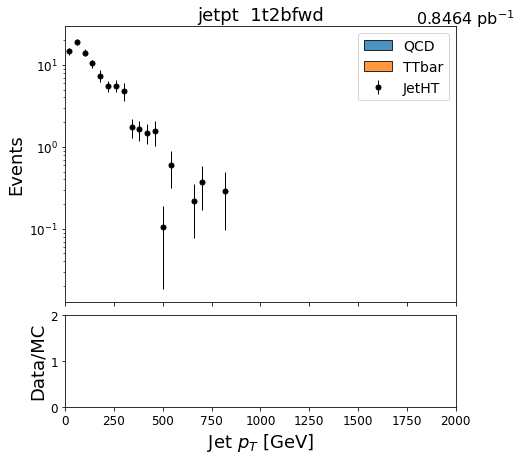

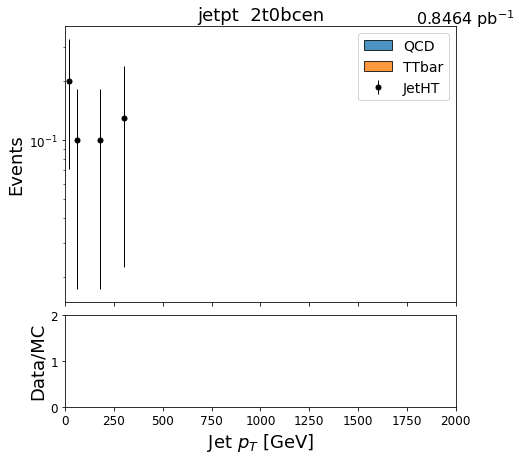

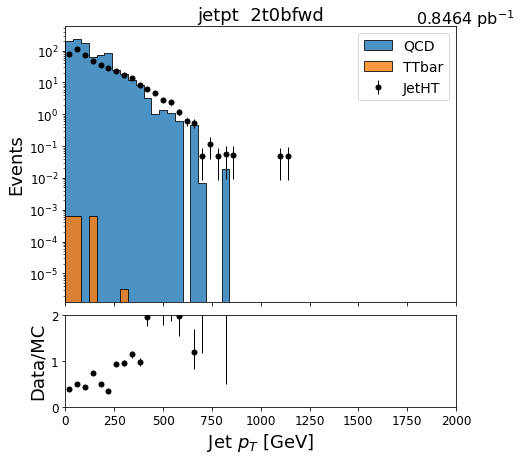

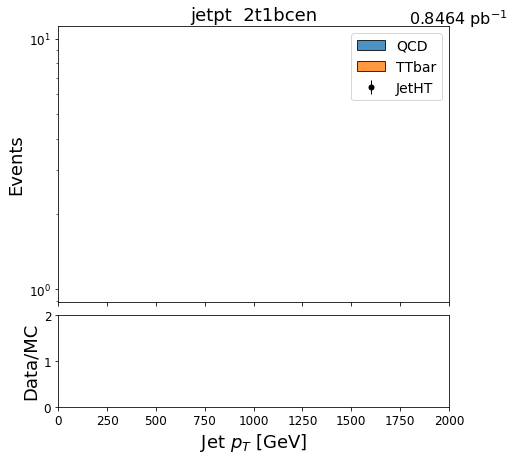

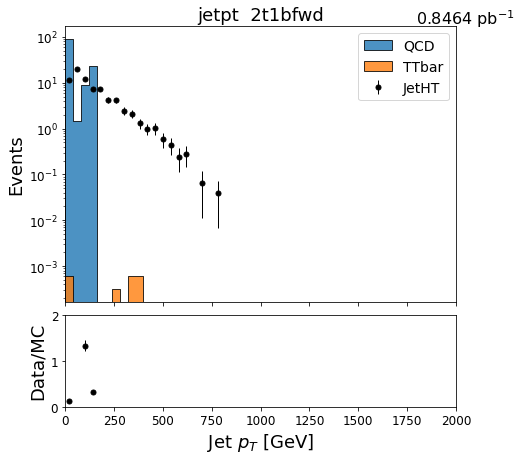

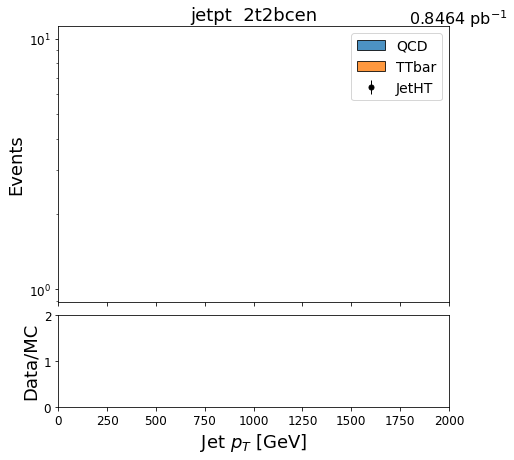

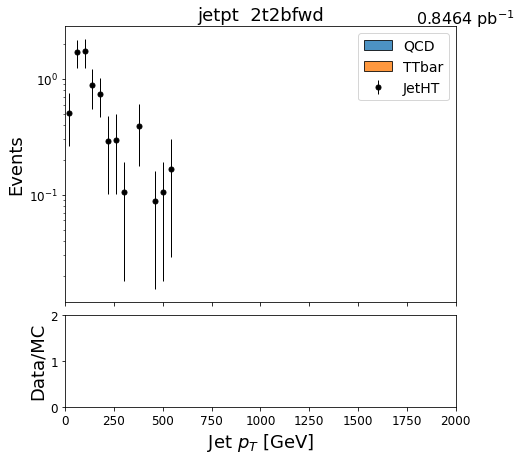

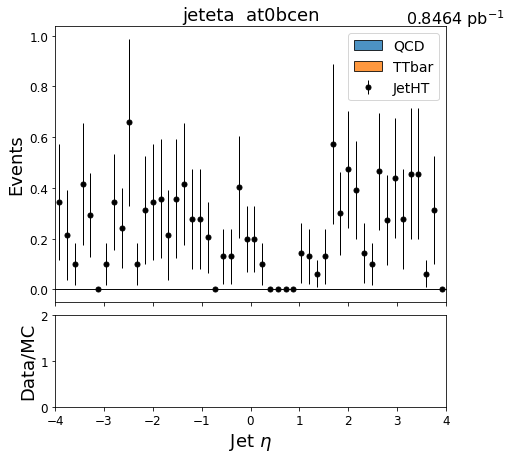

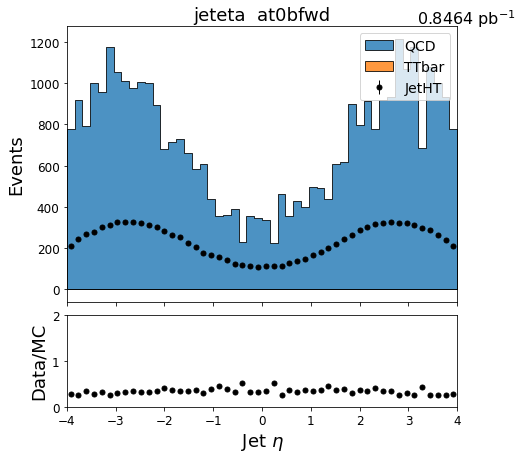

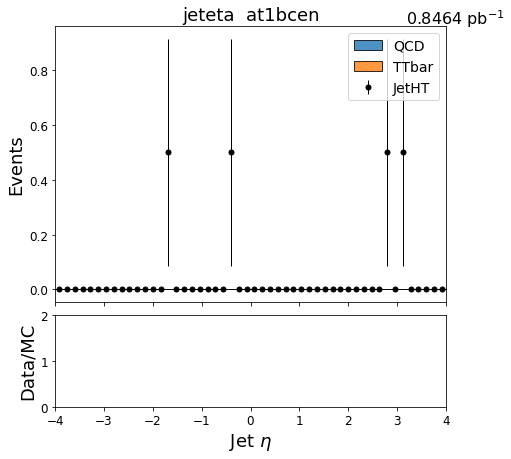

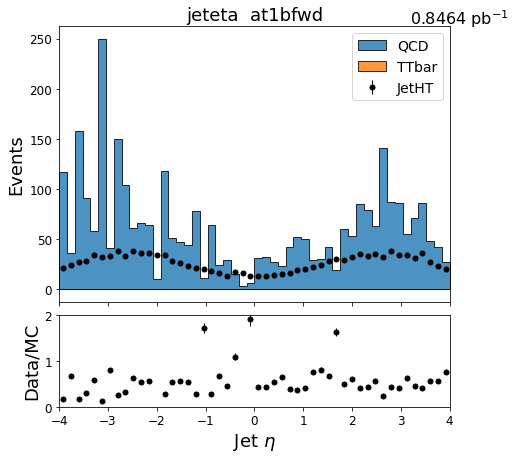

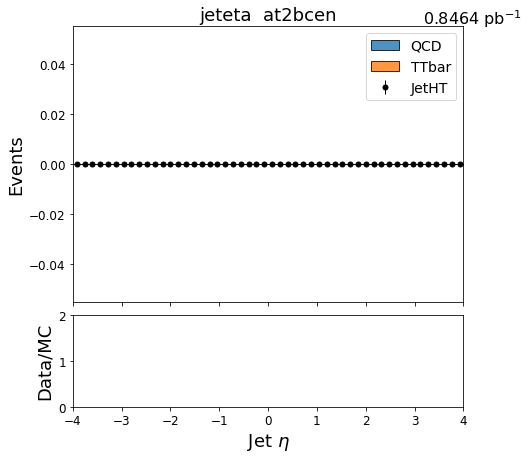

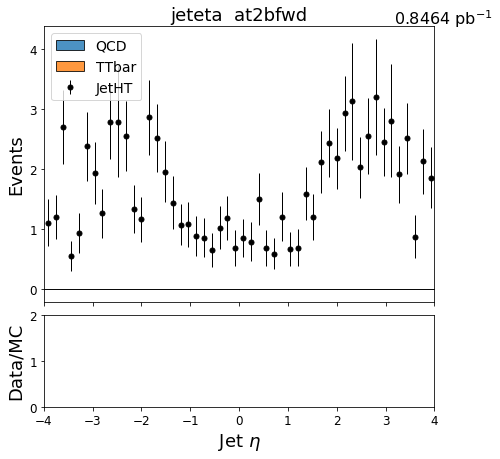

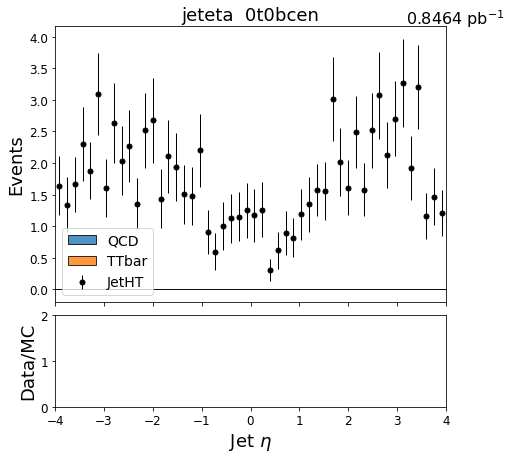

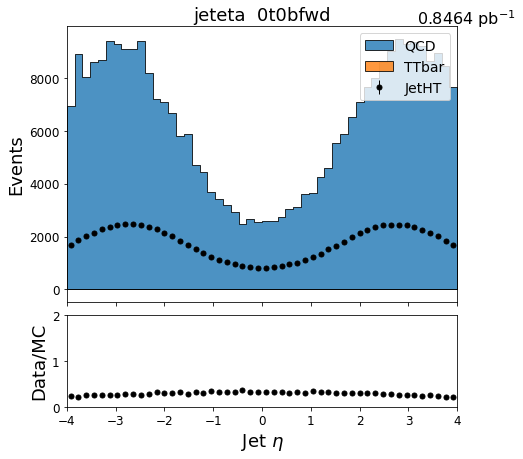

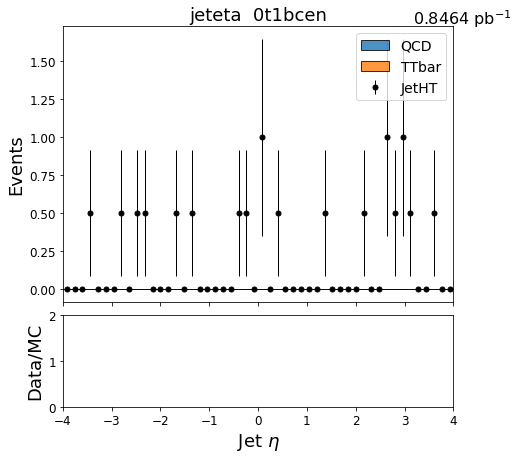

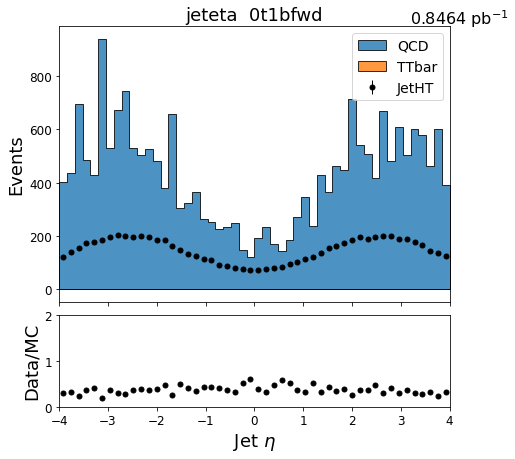

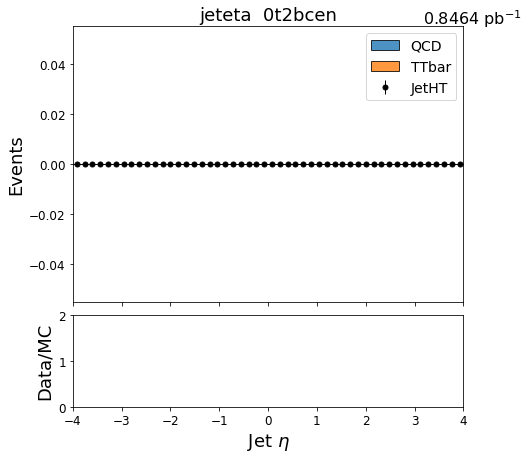

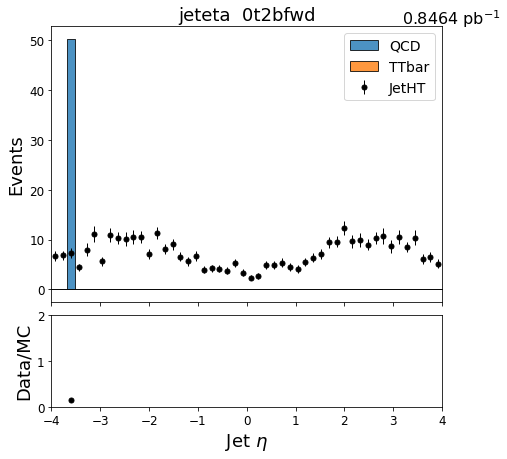

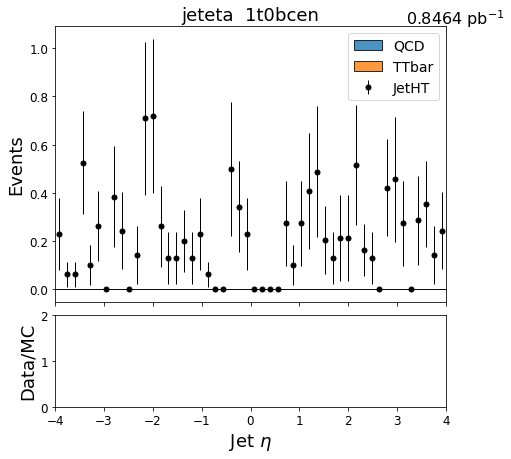

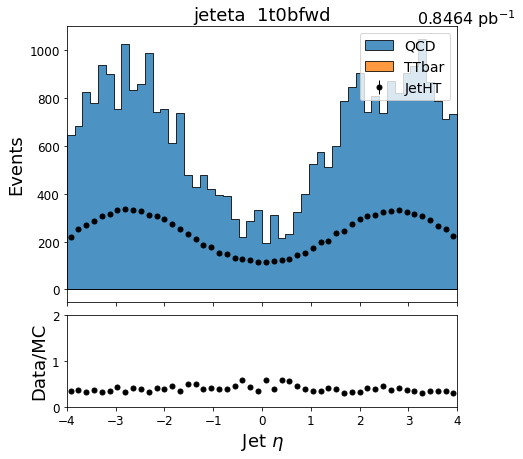

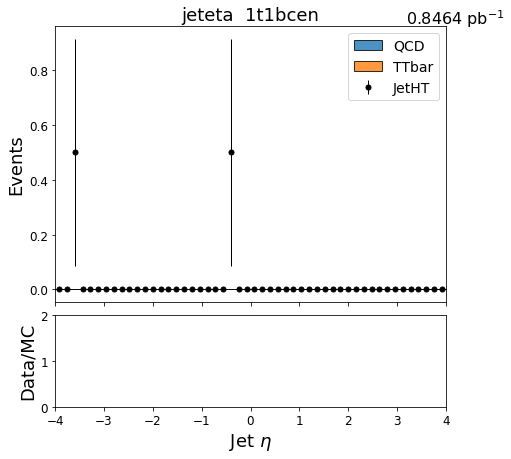

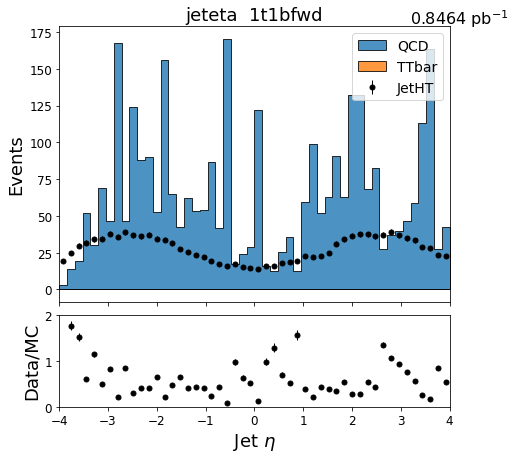

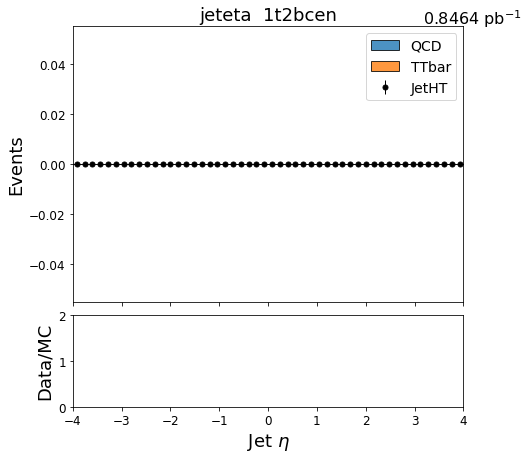

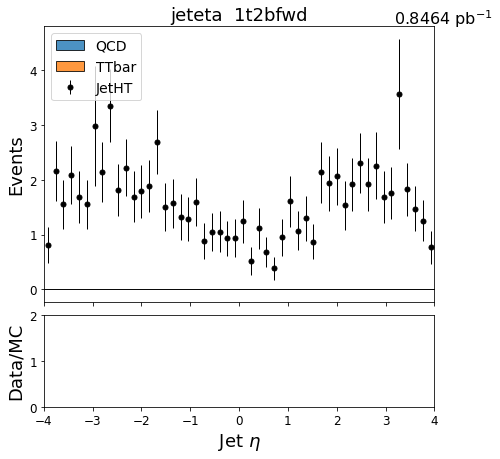

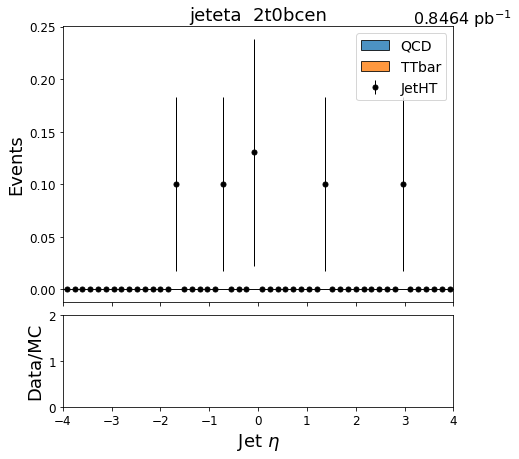

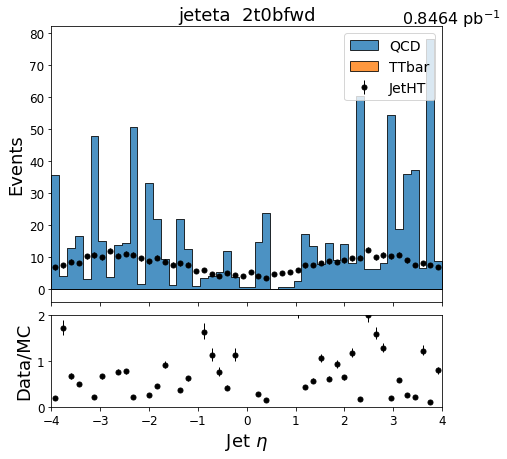

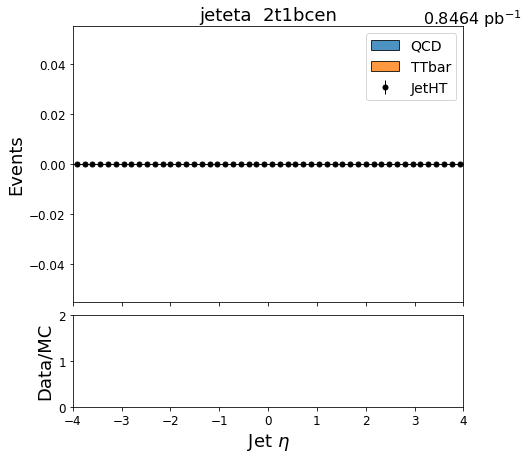

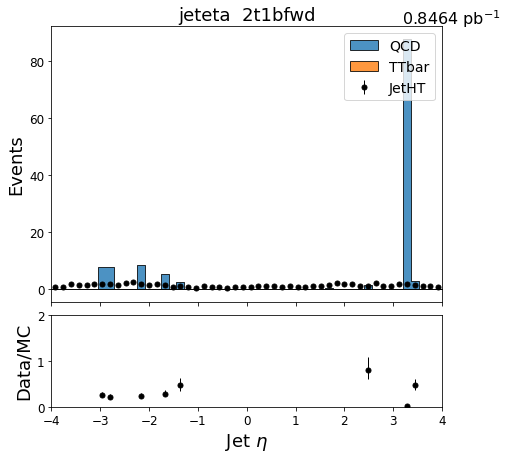

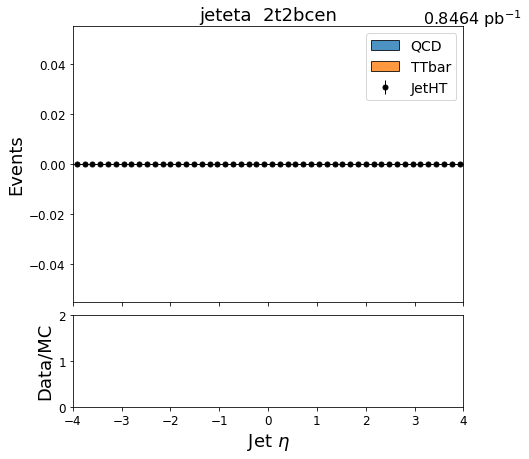

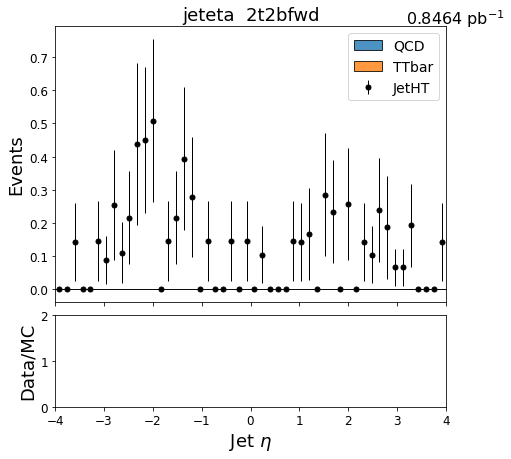

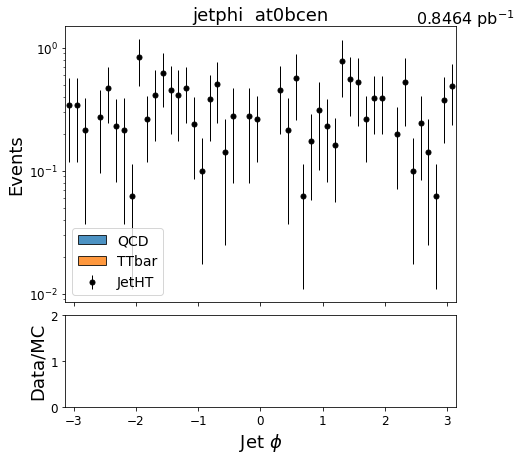

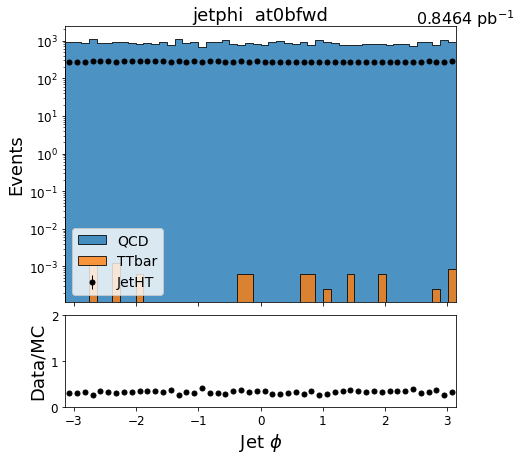

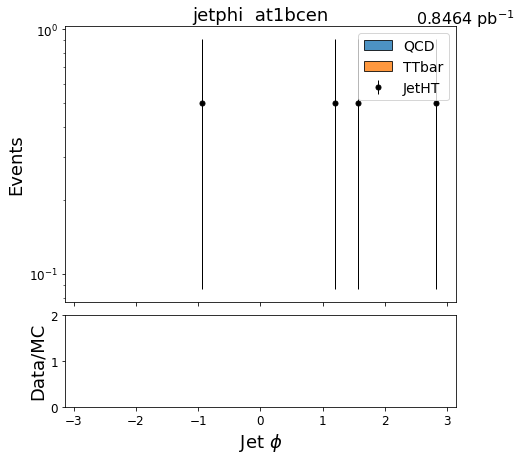

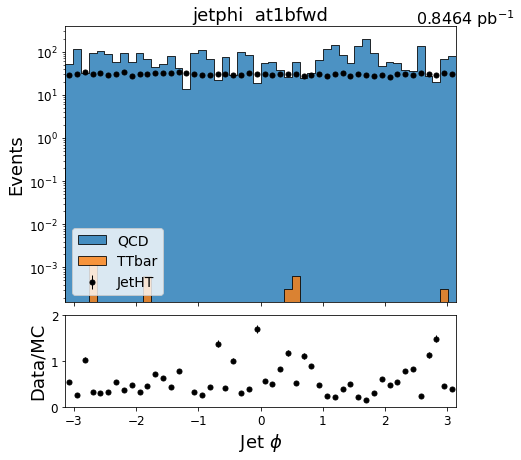

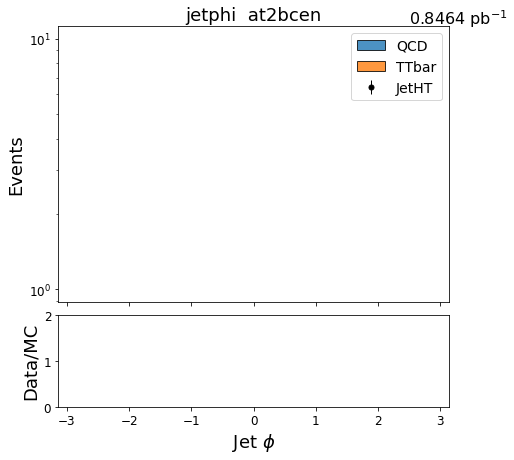

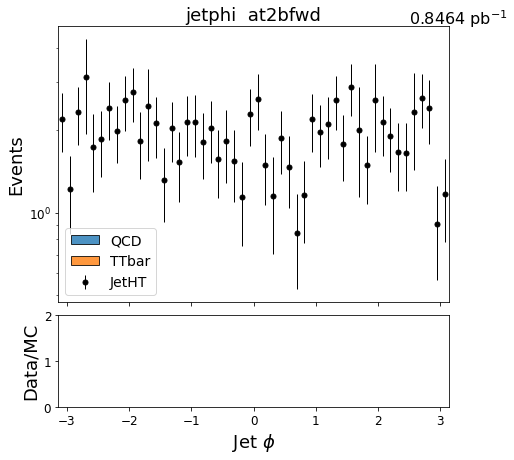

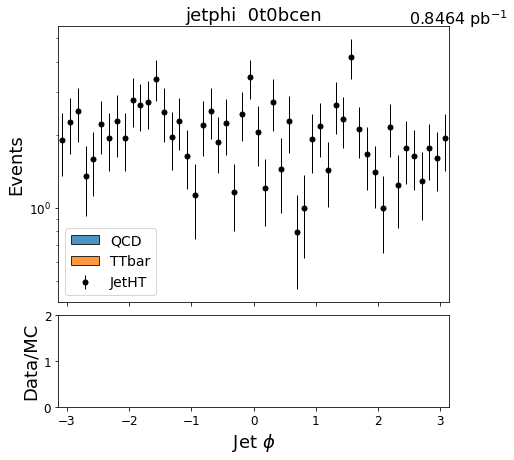

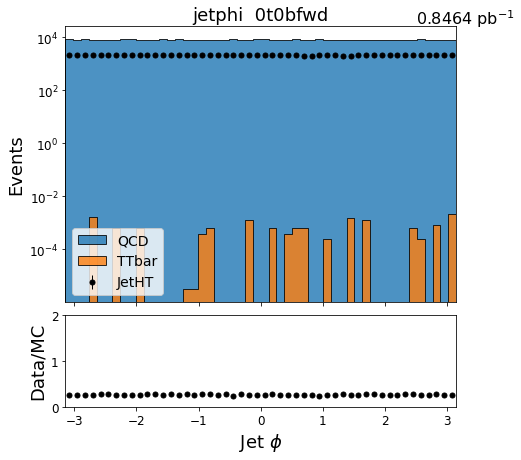

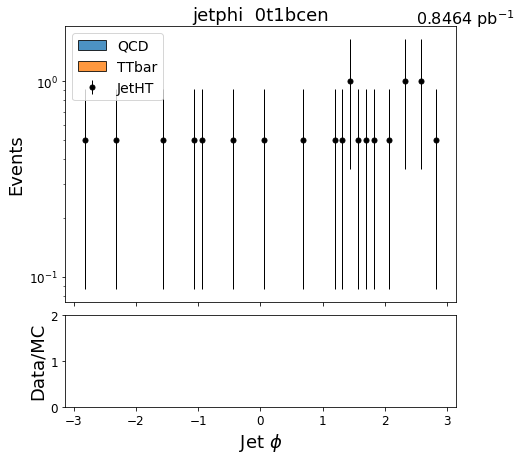

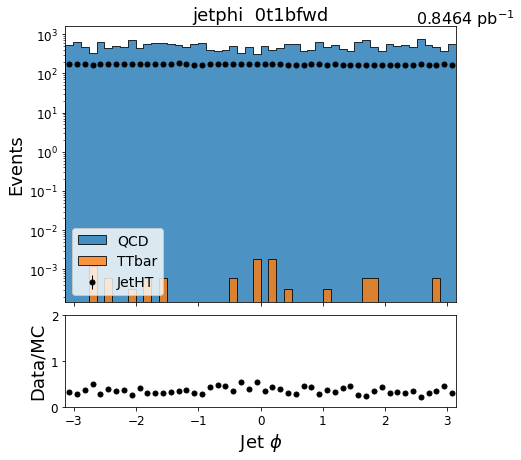

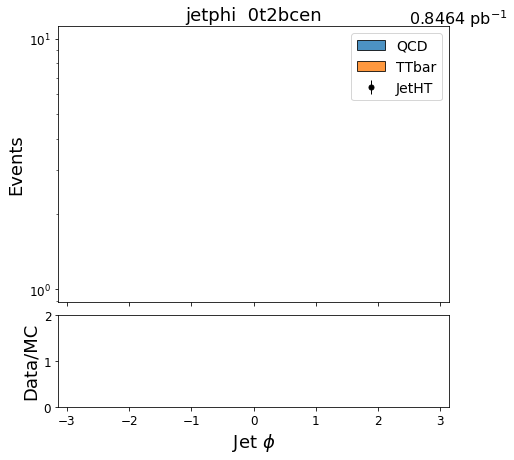

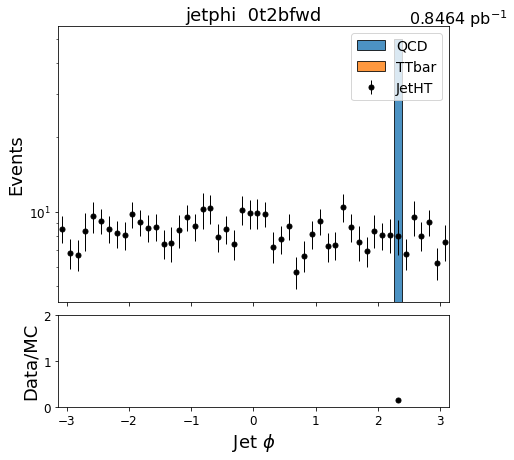

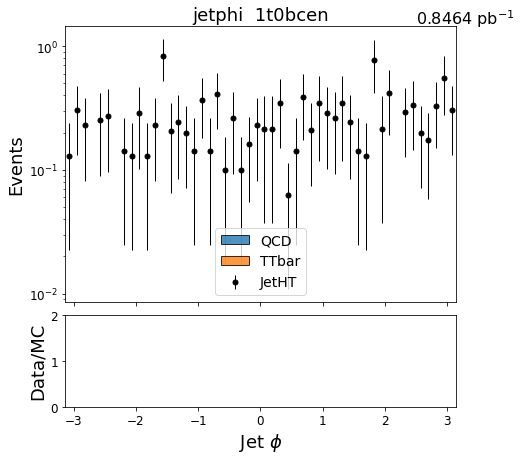

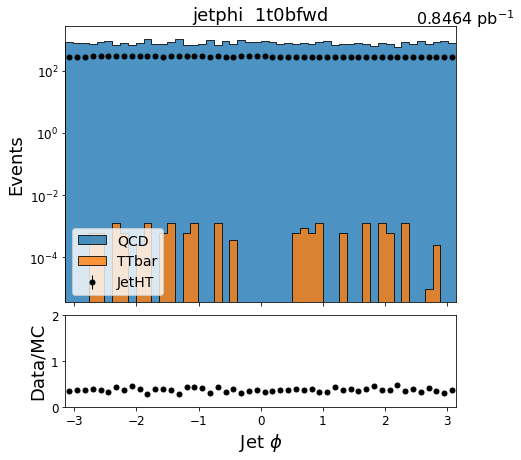

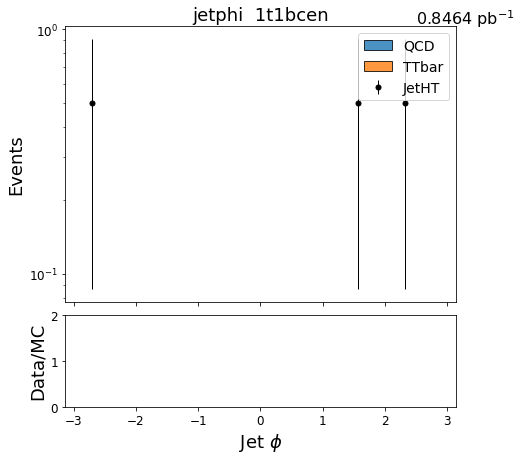

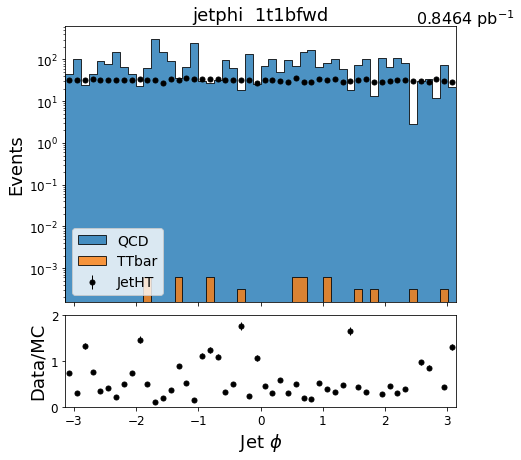

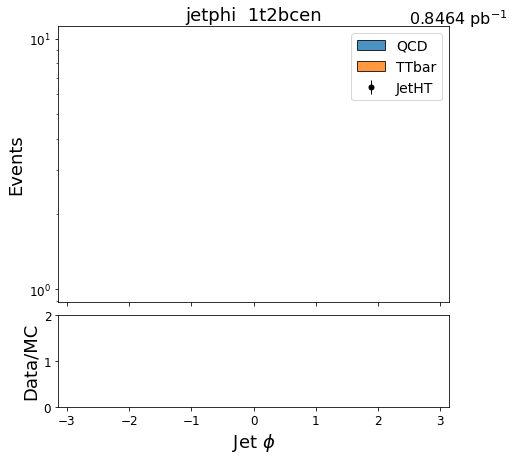

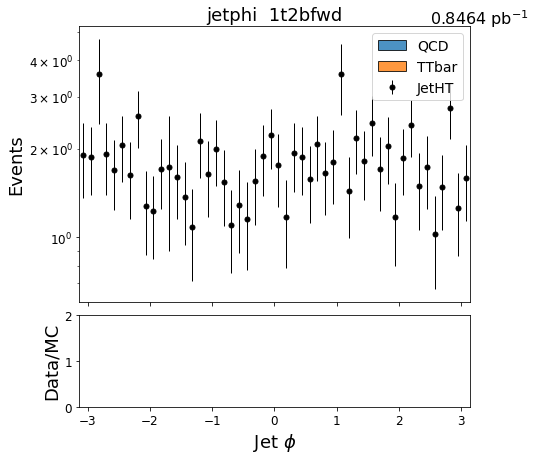

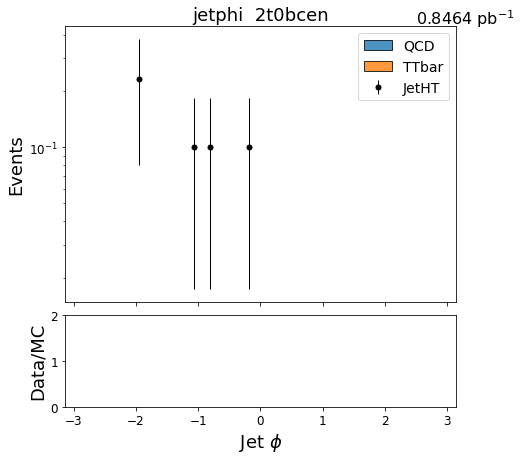

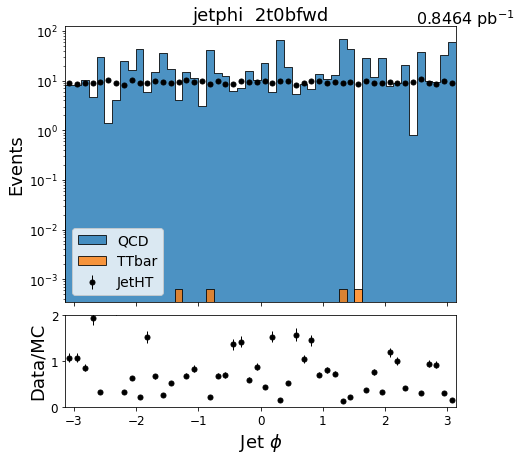

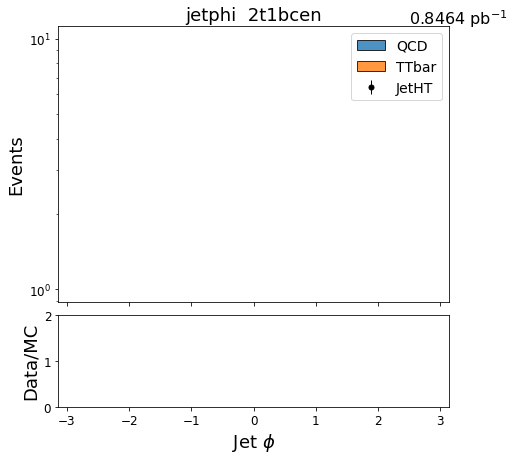

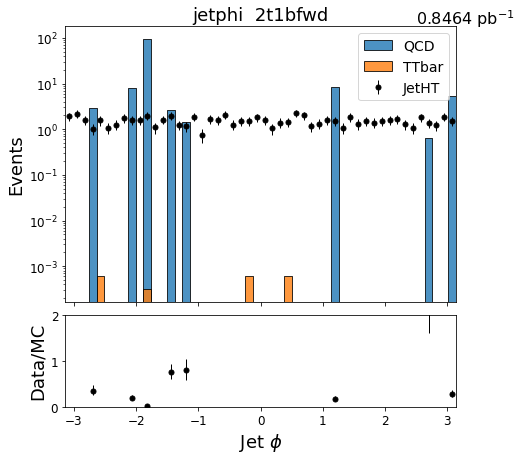

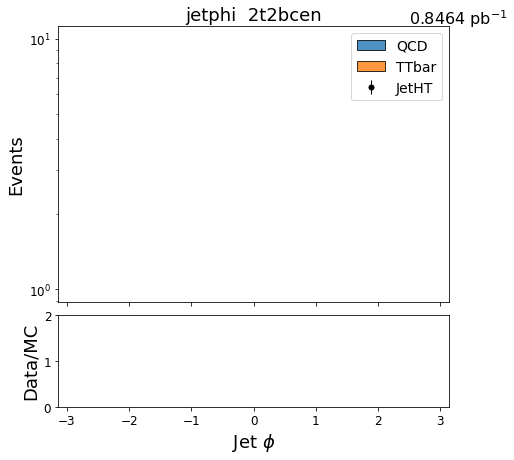

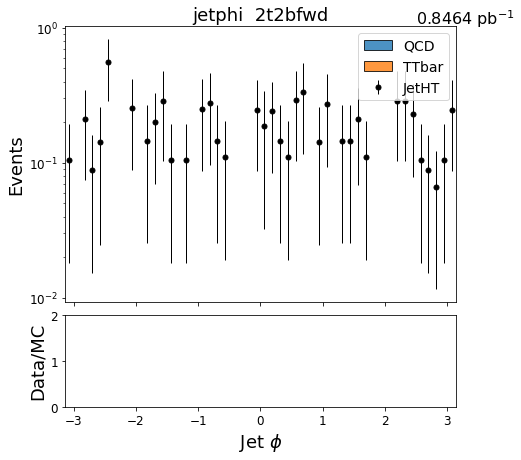

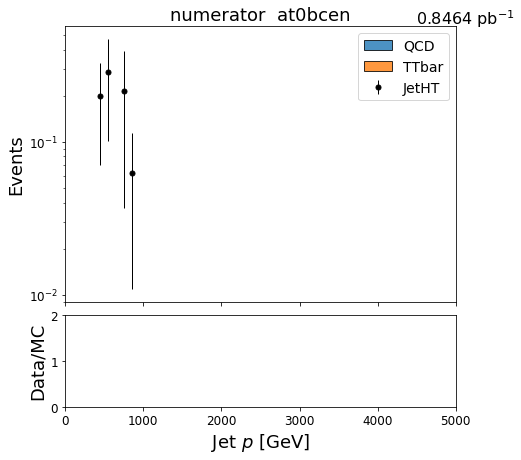

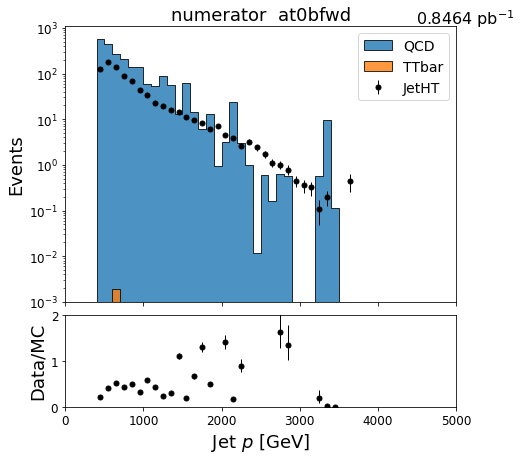

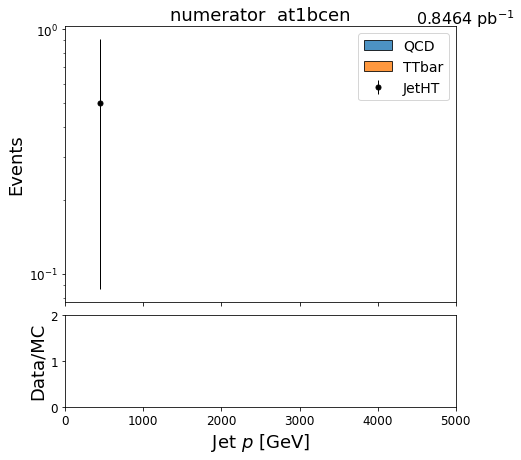

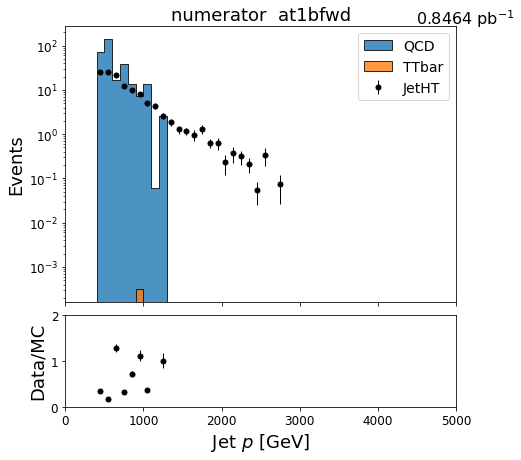

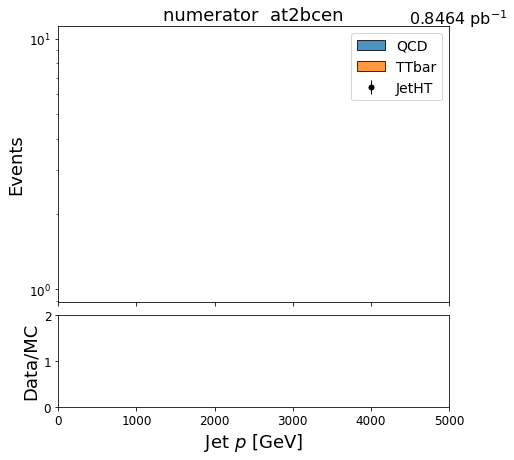

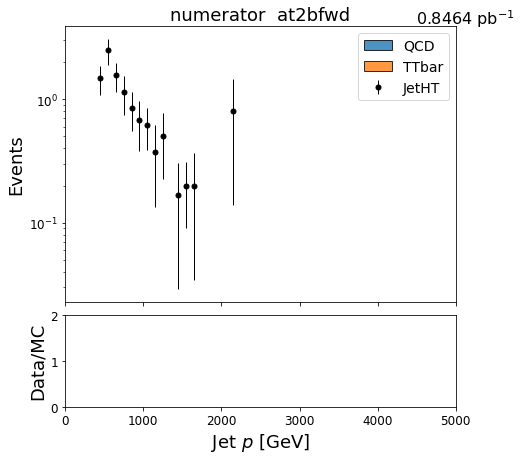

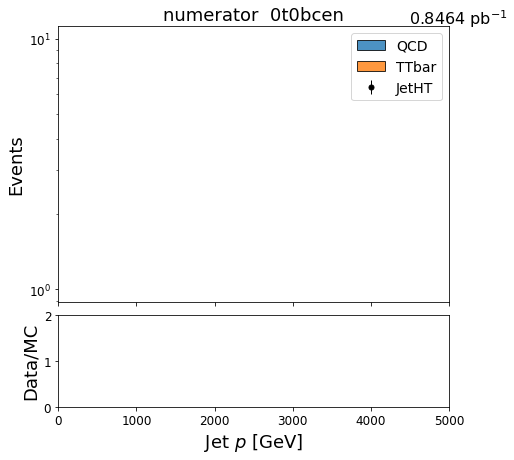

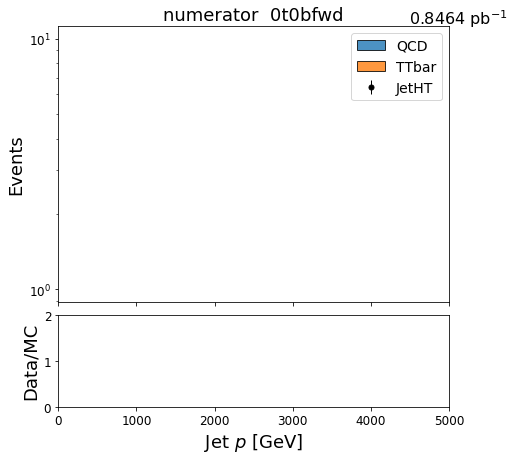

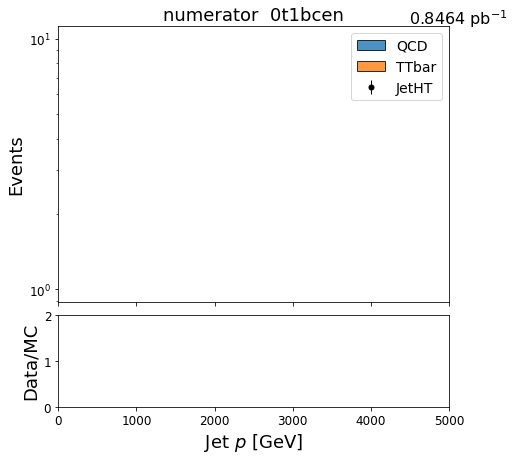

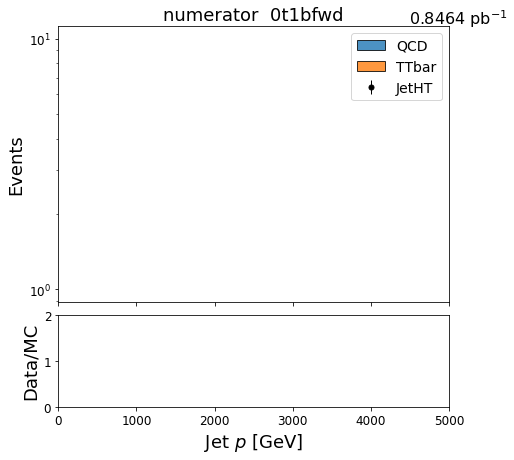

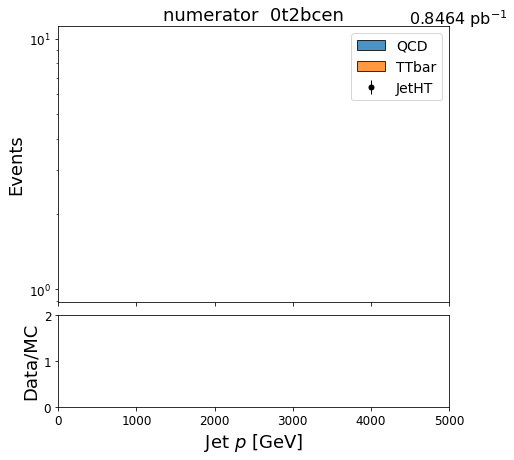

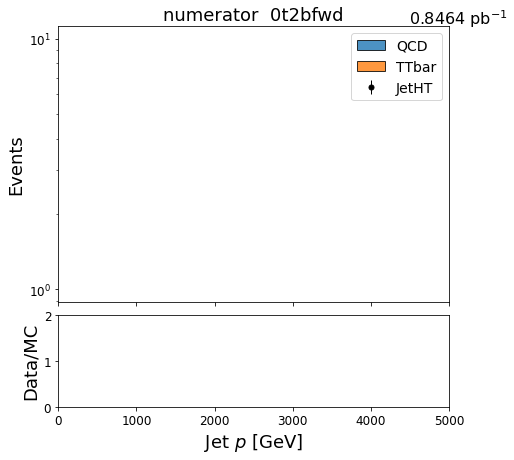

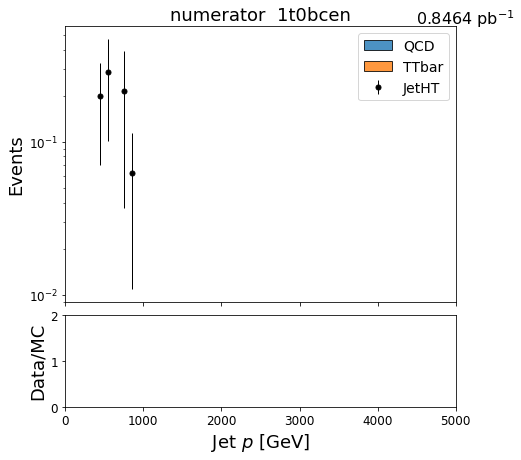

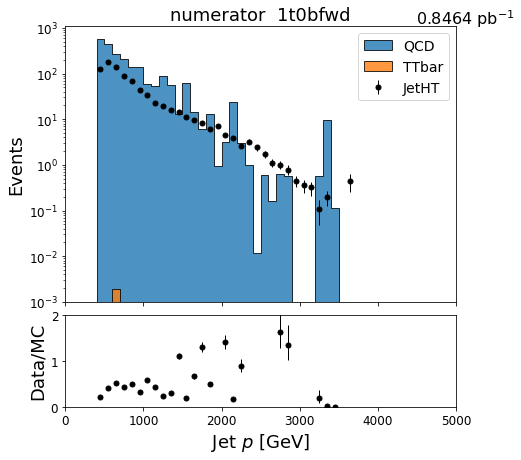

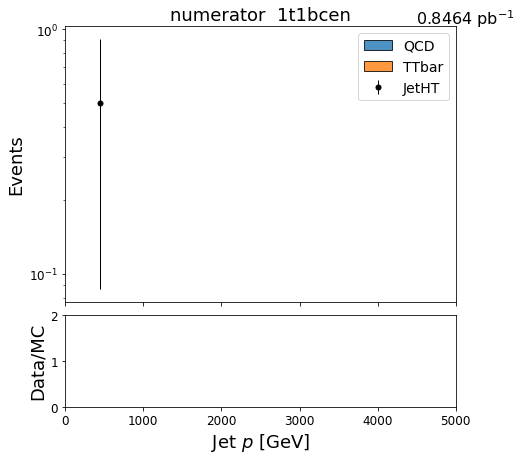

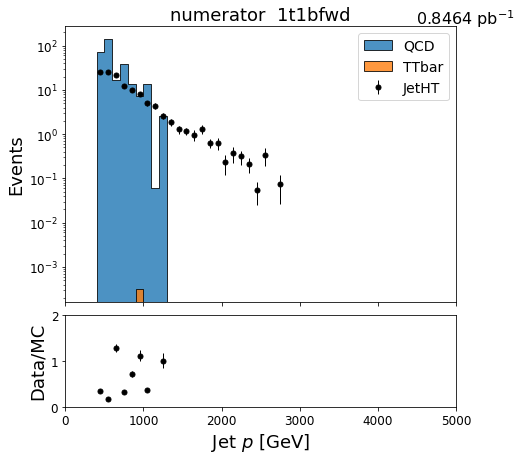

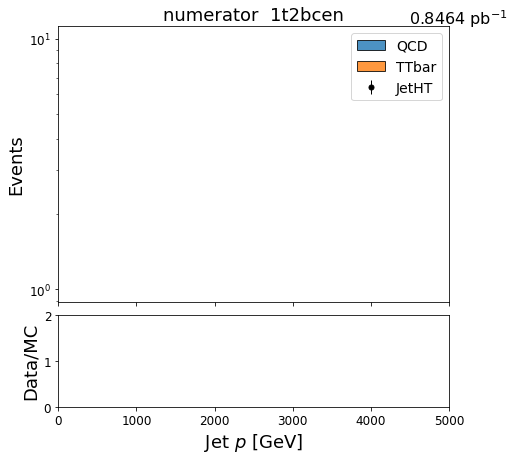

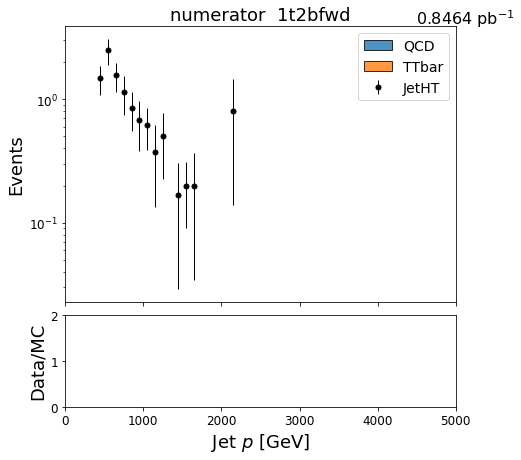

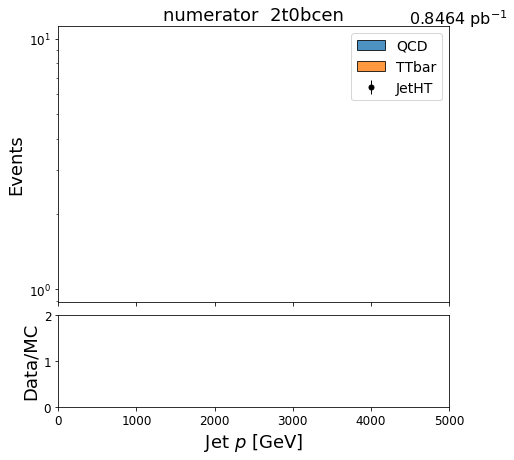

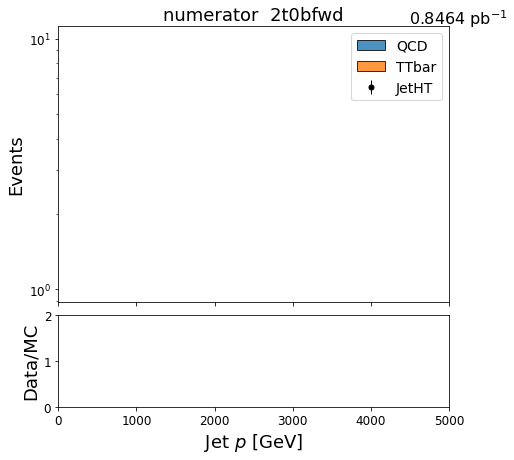

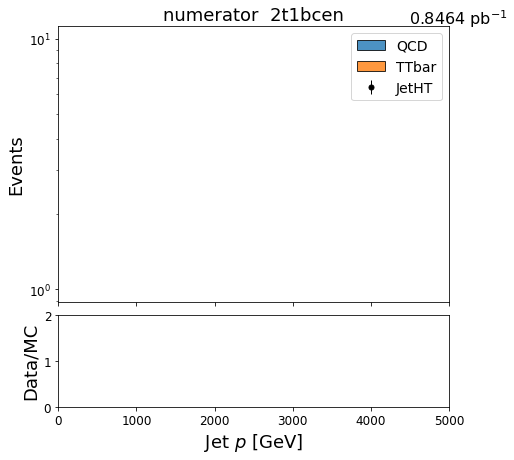

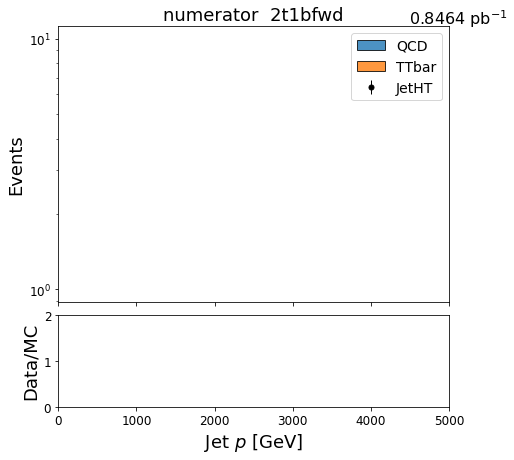

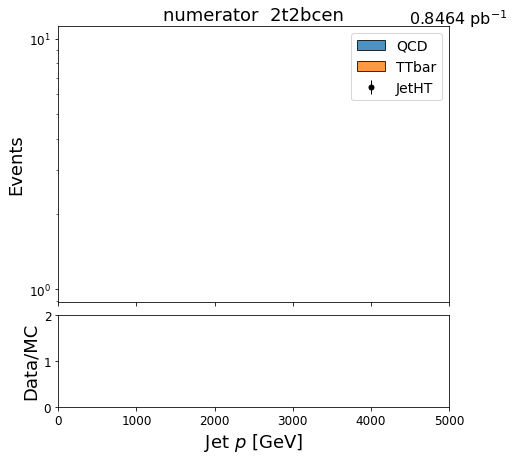

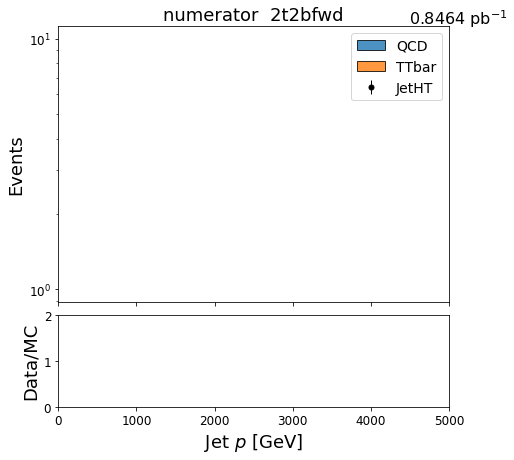

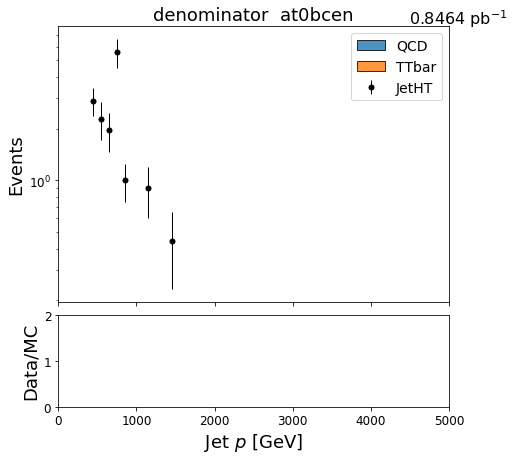

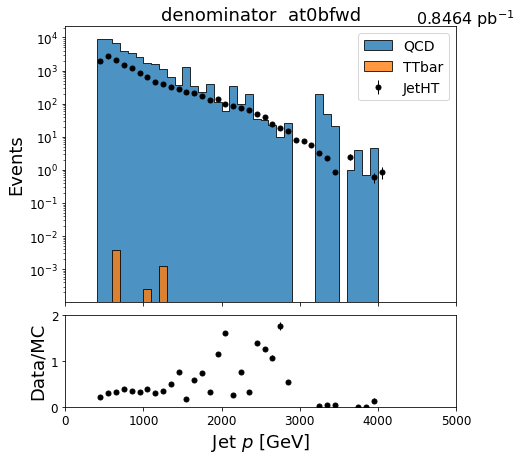

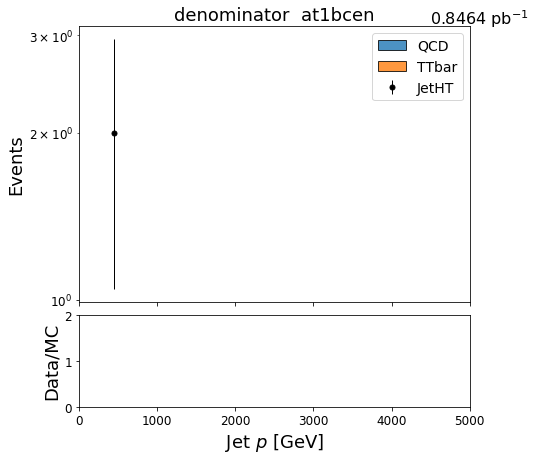

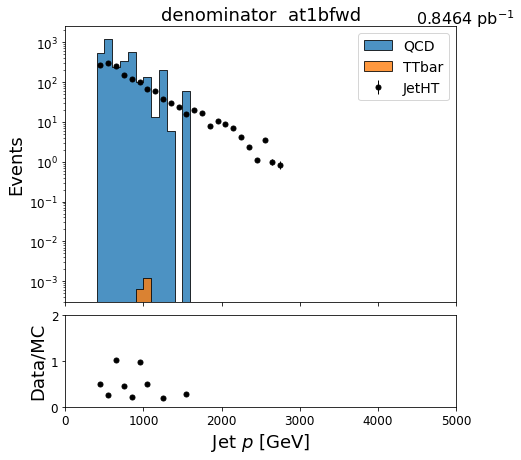

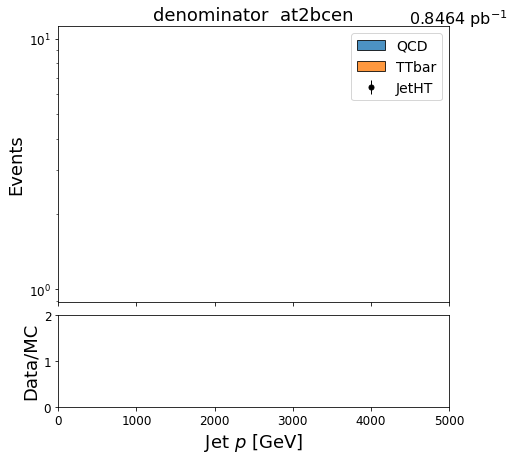

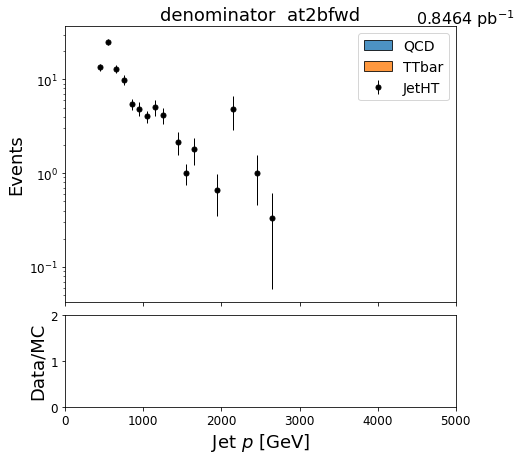

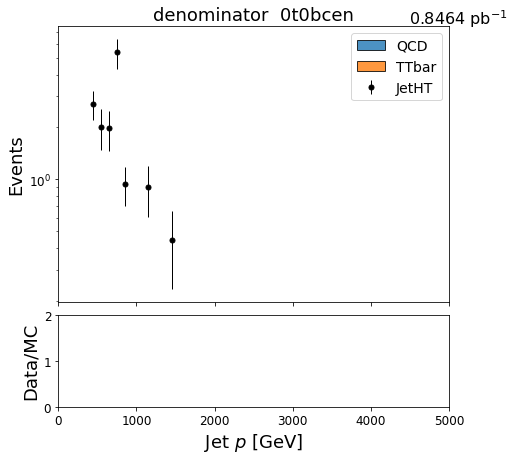

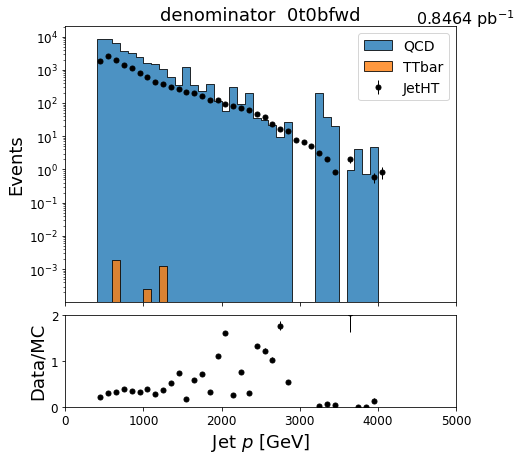

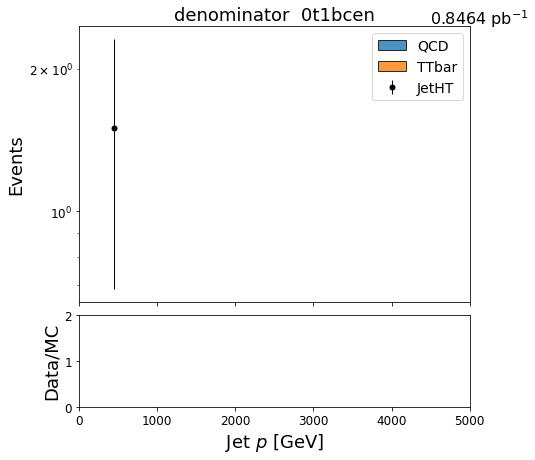

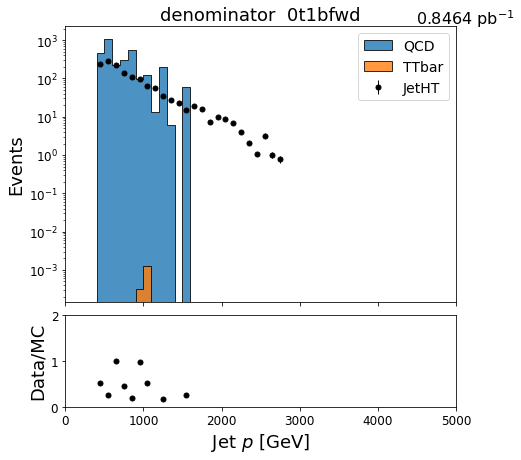

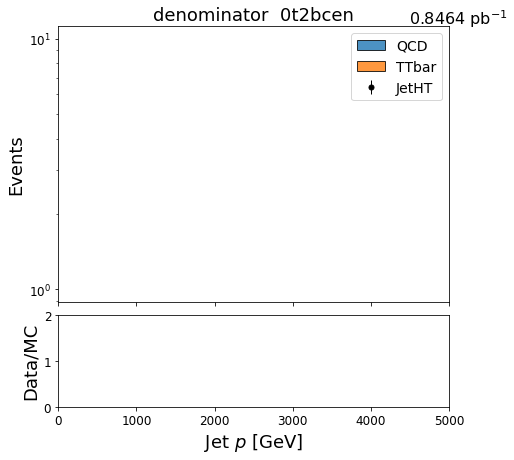

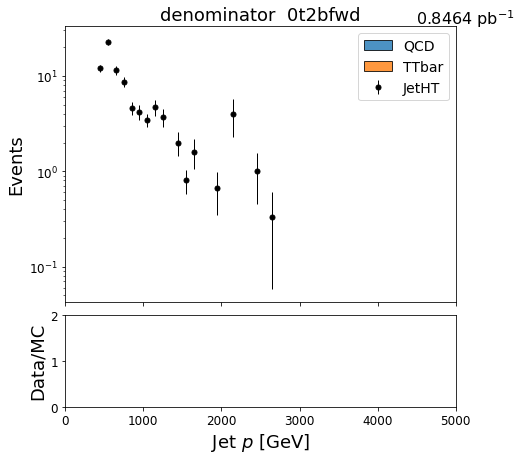

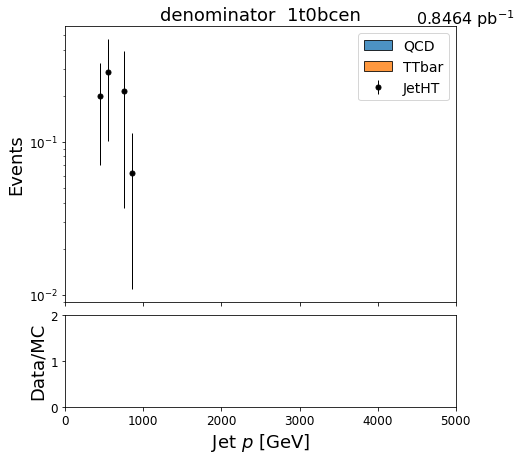

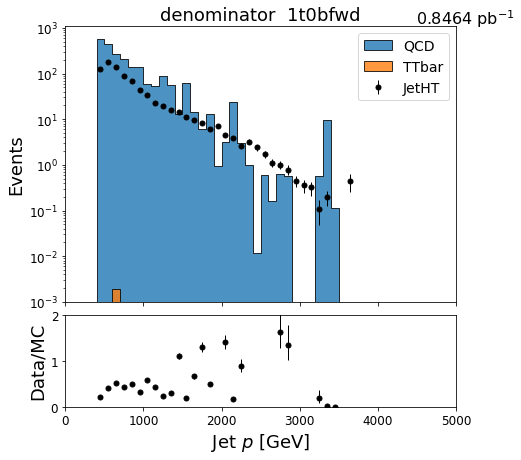

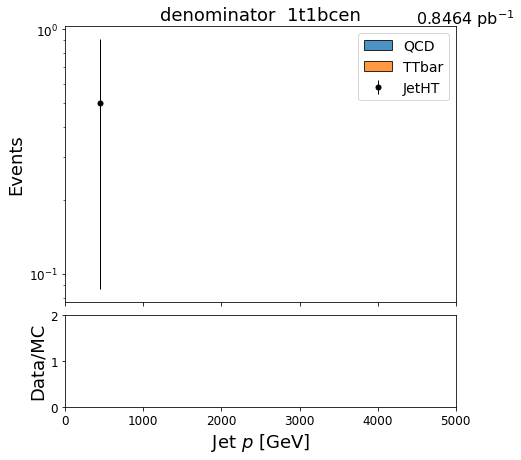

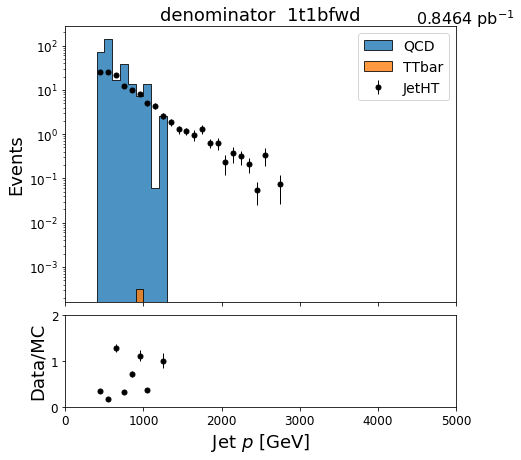

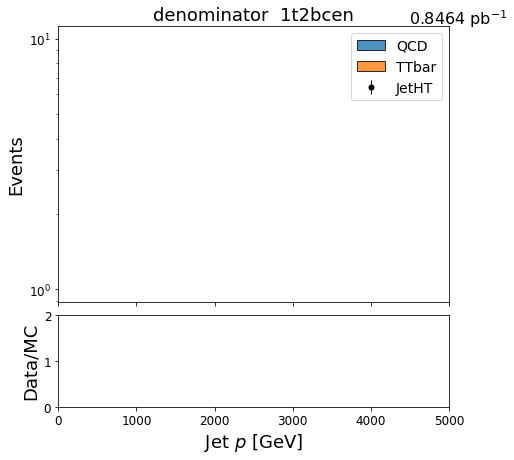

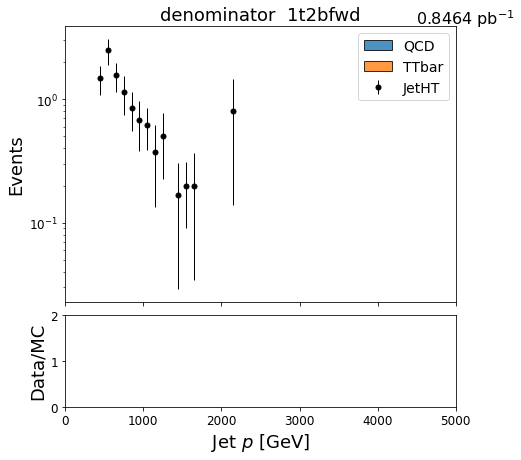

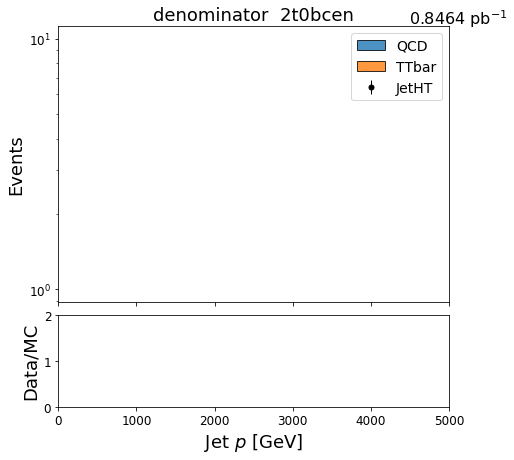

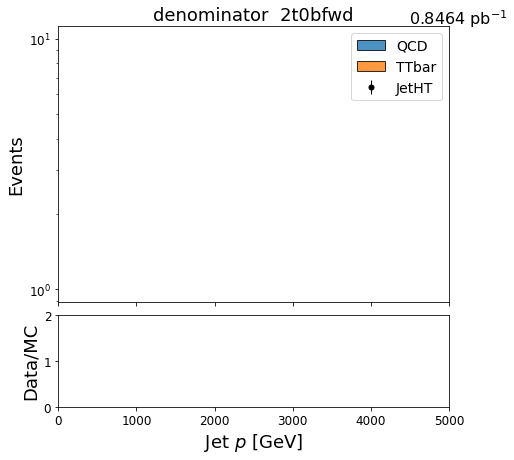

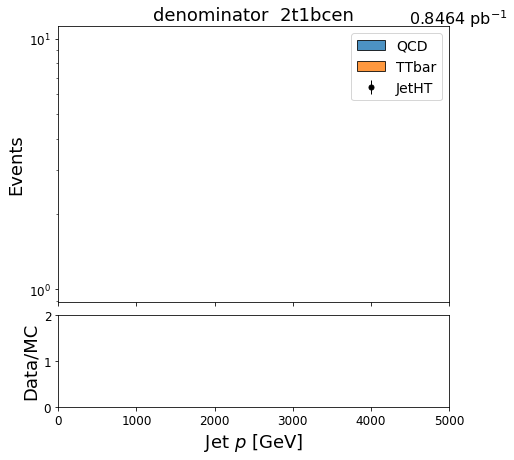

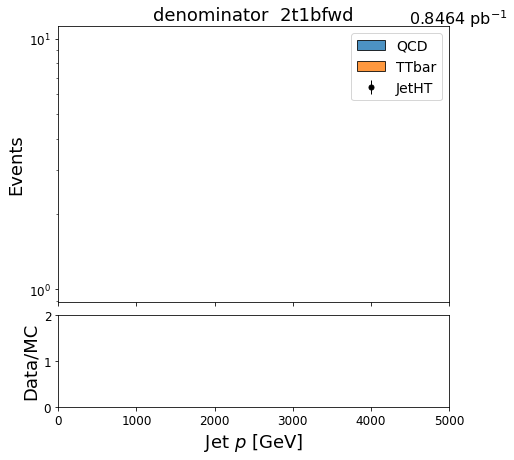

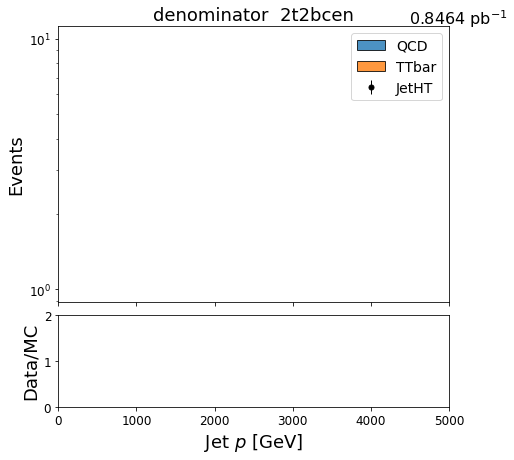

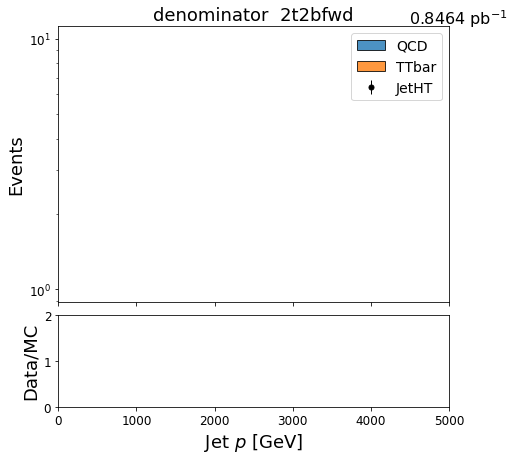

In [33]:
""" ---------------- CREATES ALL OTHER PLOTS AND RESCALES MONTE CARLO TO DATA ---------------- """
notdata = re.compile('(?!JetHT)')  

for ihist in list_of_hists:
    SaveDirectory = maindirectory + '/' + ihist + '/' # split histograms into subdirectories
    DoesDirectoryExist(SaveDirectory) # no need to create the directory several times if it exists already
    for icat in list_of_cats: 
        plt.rcParams.update({
        'font.size': 14,
        'axes.titlesize': 18,
        'axes.labelsize': 18,
        'xtick.labelsize': 12,
        'ytick.labelsize': 12
        })
        fig, (ax, rax) = plt.subplots(
            nrows=2,
            ncols=1,
            figsize=(7,7),
            gridspec_kw={"height_ratios": (3, 1)},
            sharex=True
        )
        fig.subplots_adjust(hspace=.07)
        title = ihist + '  ' + icat
        filename = ihist + '_' + icat + '.' + 'png'
        
        #---- Define Histogram by category and scale each histogram----# 
        histogram = output[ihist].integrate('anacat', icat)
        histogram.scale(scales, 'dataset') 
        
        #---- Plot MC ----#
        hist.plot1d(histogram[notdata], ax=ax, clear=False, overlay='dataset', stack=False, # stack not working
                    fill_opts=stack_fill_opts, error_opts=stack_error_opts)
        #---- Plot Data ----#
        hist.plot1d(histogram['JetHT'], ax=ax, clear=False, error_opts=data_err_opts)
        if ihist != 'jeteta':
            ax.set_yscale('log')
        else:
            pass
        ax.autoscale('y')
        ax.autoscale('x')#, tight=True) # doesn't look like its working...
        ax.set_ylabel('Events')
        ax.set_xlabel(None)
        ax.set_title(title)
        leg = ax.legend()
        
        #---- Plot Ratio ----#
        hist.plotratio(num = histogram['JetHT'].sum('dataset'), denom = histogram[notdata].sum('dataset'), ax = rax,
                       error_opts={'marker': '.', 'markersize': 10., 'color': 'k', 'elinewidth': 1},
                       unc = 'num')
        rax.set_ylabel('Data/MC')
        rax.set_ylim(0,2)
       
        #---- Labeling ----#
        Lint = str(Lum_data) # Integrated Luminosity
        lumi = plt.text(1.15, 1.07, Lint[:6] + " pb$^{-1}$",
                fontsize=16,
                horizontalalignment='right',
                verticalalignment='top',
                transform=ax.transAxes
               )
        #plt.savefig(SaveDirectory+filename, bbox_inches="tight")
        #print(filename + ' saved')
        

In [ ]:
print("Events/s:", output['cutflow']['all events']/elapsed)

In [ ]:
for i,j in output['cutflow'].items():
    print( '%20s : %12d' % (i,j) )

In [ ]:

#mapping = {
#    'QCD': ['QCD'],
#}
#output['ttbarmass'].group("dataset", hist.Cat("dataset", "dataset"), mapping)
#hist_noDS = output['ttbarmass_pretag'].integrate('dataset')


In [ ]:
# --------------- OLD METHOD OF SAVING --------------- #

"""
directory = '/uscms_data/d1/acwillia/singularity/TTbarAllHadUprootFork/TTbarAllHadUproot' # change accordingly...

SaveDirectory = directory + '/MistagPlots'
DoesDirectoryExist(SaveDirectory) # no need to create the directory several times

for iax in axes_numerator.flatten():
    category = iax.get_title()
    Numerator = output['numerator'].integrate('anacat', category).integrate('dataset', 'TTbar')
    Denominator = output['denominator'].integrate('anacat', category).integrate('dataset', 'TTbar')
    mistag = hist.plotratio(num = Numerator, denom = Denominator,
                            error_opts={'color': 'b', 'marker': 'x', 'ms':5},
                            unc = 'clopper-pearson')
    SavePlot(mistag, category, 'mistag_TTbar', 'pdf', SaveDirectory)
    


for iax in axes_numerator.flatten():
    category = iax.get_title()
    Numerator = output['numerator'].integrate('anacat', category).integrate('dataset', 'QCD')
    Denominator = output['denominator'].integrate('anacat', category).integrate('dataset', 'QCD')
    mistag = hist.plotratio(num = Numerator, denom = Denominator,
                            error_opts={'color': 'r', 'marker': '+', 'ms':5},
                            unc = 'clopper-pearson')
    SavePlot(mistag, category, 'mistag_QCD', 'pdf', SaveDirectory)
    


for iax in axes_numerator.flatten():
    category = iax.get_title()
    Numerator = output['numerator'].integrate('anacat', category).integrate('dataset', 'JetHT')
    Denominator = output['denominator'].integrate('anacat', category).integrate('dataset', 'JetHT')
    mistag = hist.plotratio(num = Numerator, denom = Denominator,
                            error_opts={'color': 'g', 'marker': '*', 'ms':5},
                            unc = 'clopper-pearson')
    SavePlot(mistag, category, 'mistag_JetHT', 'pdf', SaveDirectory)
"""    
"""___________________________________________________________________________________________________________"""
"""
SaveDirectory = directory + '/TTbarmassPlots'
DoesDirectoryExist(SaveDirectory) 
for iax in axes_ttbarmass.flatten():
    category = iax.get_title()
    bx = hist.plotgrid(output['ttbarmass'].integrate('anacat',category), overlay="dataset", stack=True, 
                       fill_opts=stack_fill_opts, error_opts=stack_error_opts)
    plt.ylim(top = 10**6, bottom=10**(-8))
    plt.yscale('log')
    SavePlot(bx, category, 'ttbarmass', 'pdf', SaveDirectory)


SaveDirectory = directory + '/NumeratorPlots'
DoesDirectoryExist(SaveDirectory) 
for iax in axes_numerator.flatten():
    category = iax.get_title()
    bx = hist.plotgrid(output['numerator'].integrate('anacat',category), overlay="dataset", stack=True,
                       fill_opts=stack_fill_opts, error_opts=stack_error_opts)
    plt.ylim(top = 10**6, bottom=10**(-8))
    plt.yscale('log')
    SavePlot(bx, category, 'numerator', 'pdf', SaveDirectory)

    

SaveDirectory = directory + '/DenominatorPlots'
DoesDirectoryExist(SaveDirectory)
for iax in axes_denominator.flatten():
    category = iax.get_title()
    bx = hist.plotgrid(output['denominator'].integrate('anacat',category), overlay="dataset", stack=True,
                       fill_opts=stack_fill_opts, error_opts=stack_error_opts)
    plt.ylim(top = 10**6, bottom=10**(-8))
    plt.yscale('log')
    SavePlot(bx, category, 'denominator', 'pdf', SaveDirectory)



SaveDirectory = directory + '/JetptPlots'
DoesDirectoryExist(SaveDirectory)
for iax in axes_denominator.flatten():
    category = iax.get_title()
    bx = hist.plotgrid(output['jetpt'].integrate('anacat',category), overlay="dataset", stack=True,
                       fill_opts=stack_fill_opts, error_opts=stack_error_opts)
    plt.ylim(top = 10**6, bottom=10**(-8))
    plt.yscale('log')
    SavePlot(bx, category, 'jetpt', 'pdf', SaveDirectory)


SaveDirectory = directory + '/JetetaPlots'
DoesDirectoryExist(SaveDirectory)
for iax in axes_denominator.flatten():
    category = iax.get_title()
    bx = hist.plotgrid(output['jeteta'].integrate('anacat',category), overlay="dataset", stack=True,
                       fill_opts=stack_fill_opts, error_opts=stack_error_opts)
    plt.ylim(top = 10**6, bottom=10**(-8))
    plt.yscale('log')
    SavePlot(bx, category, 'jeteta', 'pdf', SaveDirectory)


SaveDirectory = directory + '/JetphiPlots'
DoesDirectoryExist(SaveDirectory)
for iax in axes_denominator.flatten():
    category = iax.get_title()
    bx = hist.plotgrid(output['jetphi'].integrate('anacat',category), overlay="dataset", stack=True,
                       fill_opts=stack_fill_opts, error_opts=stack_error_opts)
    plt.ylim(top = 10**6, bottom=10**(-8))
    plt.yscale('log')
    SavePlot(bx, category, 'jetphi', 'pdf', SaveDirectory)
"""